# Capstone Project
## Extraction, cleaning, and merging of data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import sys
import itertools
import time
import random
import time

import matplotlib as mpl
import matplotlib.pyplot as plt # for plotting graphs
from matplotlib.pylab import rcParams # To configure Matplotlib settings
import seaborn as sns # for plotting graphs
import datetime as dt

from scipy import stats # Boxcox transformation
import scipy.cluster.hierarchy as sch # Dendogram visualization

from sklearn import preprocessing, linear_model
from sklearn.model_selection import KFold, train_test_split
from kneed import KneeLocator # To computationally identify the ideal cluster for cluster based models
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering # Clustering methods
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, mean_squared_error, mean_absolute_error
from yellowbrick.cluster import KElbowVisualizer

# Time Series Modelling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Facebook time series model
from prophet import Prophet

# Set Pandas settings to display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
# Read dataset
dfSKU = pd.read_csv(r"gtn_es_rev_account_sku_9Feb22.csv", dtype={'cust_id': str},
                 delimiter=",", encoding='utf-8', parse_dates=['pstng_dt'], infer_datetime_format=True)

#SKU Columns in dataset
# 'acct_doc_nmbr', 'fscl_yr', 'fscl_mo', 'fscl_yr_mo', 'cmpny_id', 'prod_name', 'cust_group', 'cust_id', 'cust_name', 'pstng_dt', 'amt', 'qty', 'pk_sku'

dfDeduc = pd.read_csv(r"gtn_es_rev_account_deduction_9Feb22.csv",
                 delimiter=",", encoding='utf-8')

#Deduction Columns in dataset
# 'acct_doc_nmbr', 'fscl_yr', 'fscl_yr_mo', 'gl_acct_id', 'gl_acct_desc', 'prod_name', 'qty', 'deduction_type', 'amt', 'pk_sku', 'cmpny_id'

In [3]:
# Replace whitespace with underscore in dfSKU
dfSKU = dfSKU.replace(' ', '_', regex=True)
dfSKU

acct_doc_nmbr  fscl_yr  fscl_mo  fscl_yr_mo  cmpny_id prod_name  \
0           800040622     2020       12      202012    404637    Drug_2   
1           800040623     2020       12      202012    404637    Drug_2   
2          8200008460     2020       11      202011    404637    Drug_1   
3           800040682     2020       12      202012    404637    Drug_1   
4           800040682     2020       12      202012    404637    Drug_1   
...               ...      ...      ...         ...       ...       ...   
148446       53088400     2021        5      202105    404637    Drug_1   
148447       53088468     2021        5      202105    404637    Drug_1   
148448       53088475     2021        5      202105    404637    Drug_2   
148449       53088476     2021        5      202105    404637    Drug_2   
148450       53088408     2021        5      202105    404637    Drug_1   

           cust_group cust_id    cust_name   pstng_dt         amt        qty  \
0              OTHERS       #          NaN 2020-12-14 -1335346.72 -115005.00   
1              OTHERS       #          NaN 2020-12-14        0.00       0.00   
2              OTHERS       #          NaN 2020-11-30        0.00       0.00   
3              OTHERS       #          NaN 2020-12-10        0.00       0.00   
4              OTHERS       #          NaN 2020-12-10        0.00       0.00   
...               ...     ...          ...        ...         ...        ...   
148446  MISCELLANEOUS  555997   Customer_8 2021-05-27     1422.18      10.00   
148447  MISCELLANEOUS  555577  Customer_15        NaT        0.00        NaN   
148448  MISCELLANEOUS  555577  Customer_15        NaT        0.00        NaN   
148449  MISCELLANEOUS  555577  Customer_15        NaT        0.00        NaN   
148450  MISCELLANEOUS  555577  Customer_15        NaT        0.00        NaN   

                              pk_sku  
0        800040622Drug_2404637202012  
1        800040623Drug_2404637202012  
2       8200008460Drug_1404637202011  
3        800040682Drug_1404637202012  
4        800040682Drug_1404637202012  
...                              ...  
148446    53088400Drug_1404637202105  
148447    53088468Drug_1404637202105  
148448    53088475Drug_2404637202105  
148449    53088476Drug_2404637202105  
148450    53088408Drug_1404637202105  

[148451 rows x 13 columns]

In [4]:
# Replace whitespace with underscore in dfDeduc
dfDeduc = dfDeduc.replace(' ', '_', regex=True)
dfDeduc

acct_doc_nmbr  fscl_yr  fscl_yr_mo  gl_acct_id  \
0           800040683     2020      202012    10109007   
1           800040623     2020      202012    10101900   
2           800040623     2020      202012    10101900   
3           800040623     2020      202012    10101001   
4           808080280     2020      202012    10103001   
...               ...      ...         ...         ...   
208870       53088476     2021      202105    10101000   
208871       53088476     2021      202105    10101000   
208872       53088408     2021      202105    10101000   
208873       53088408     2021      202105    10101000   
208874       53088585     2021      202105    10101000   

                                    gl_acct_desc prod_name  qty  \
0       Sales_Rebates_-_Other_Manual_Adjustments    Drug_1    0   
1           Revenue_Credits_-_Manual_Adjustments    Drug_1    0   
2           Revenue_Credits_-_Manual_Adjustments    Drug_1    0   
3         Sales_Chargebacks_-_Manual_Adjustments    Drug_1    0   
4          Sales_Allowances_-_Manual_Adjustments    Drug_2    0   
...                                          ...       ...  ...   
208870                Sales_On_Invoice_Discounts    Drug_2    0   
208871                Sales_On_Invoice_Discounts    Drug_2    0   
208872                Sales_On_Invoice_Discounts    Drug_2    0   
208873                         Sales_Chargebacks    Drug_1    0   
208874                Sales_On_Invoice_Discounts    Drug_2    0   

           deduction_type        amt                       pk_sku  cmpny_id  
0           Sales_Rebates    8883.66  800040683Drug_1404637202012    404637  
1               Discounts     726.45  800040623Drug_1404637202012    404637  
2               Discounts   -4892.63  800040623Drug_1404637202012    404637  
3       Sales_Chargebacks 1086062.71  800040623Drug_1404637202012    404637  
4        Sales_Allowances   -6174.48   808080280Drug_237492202012     37492  
...                   ...        ...                          ...       ...  
208870          Discounts      -1.18   53088476Drug_2404637202105    404637  
208871          Discounts      -9.80   53088476Drug_2404637202105    404637  
208872          Discounts      -4.76   53088408Drug_2404637202105    404637  
208873  Sales_Chargebacks   -8064.51   53088408Drug_1404637202105    404637  
208874          Discounts    -253.52   53088585Drug_2404637202105    404637  

[208875 rows x 11 columns]

In [5]:
print(f"Is null values present in SKU? {dfSKU.isnull().values.any()}")
print(f"Is null values present in Deduction? {dfDeduc.isnull().values.any()}")

print(f"Total number of null values in SKU: \n{dfSKU.isnull().sum()}")
print(f"SKU dataframe shape details {dfSKU.shape}")
dfSKU = dfSKU.dropna(subset=['qty', 'cust_name']).copy()
print(f"Total number of null values in SKU after dropping data: \n{dfSKU.isnull().sum()}")

# Quantity can't be zero
# print(f"Check total row count that contains zeroes:\n{dfSKU.isin([0]).sum()}")
# dfSKU = dfSKU[dfSKU['qty'] != 0]
# print(f"Check total row count that contains zeroes:\n{dfSKU.isin([0]).sum()}")
print(f"SKU dataframe shape details {dfSKU.shape}")
print(f"SKU dataframe column datatypes:\n{dfSKU.dtypes}")

Is null values present in SKU? True
Is null values present in Deduction? False
Total number of null values in SKU: 
acct_doc_nmbr        0
fscl_yr              0
fscl_mo              0
fscl_yr_mo           0
cmpny_id             0
prod_name            0
cust_group           0
cust_id              0
cust_name         1357
pstng_dt         45749
amt                  0
qty              45749
pk_sku               0
dtype: int64
SKU dataframe shape details (148451, 13)
Total number of null values in SKU after dropping data: 
acct_doc_nmbr    0
fscl_yr          0
fscl_mo          0
fscl_yr_mo       0
cmpny_id         0
prod_name        0
cust_group       0
cust_id          0
cust_name        0
pstng_dt         0
amt              0
qty              0
pk_sku           0
dtype: int64
SKU dataframe shape details (101345, 13)
SKU dataframe column datatypes:
acct_doc_nmbr             int64
fscl_yr                   int64
fscl_mo                   int64
fscl_yr_mo                int64
cmpny_id     

In [6]:
# display(dfSKU[dfSKU['cust_id'] == 555094].sort_values(by='pstng_dt', ascending=False))
# display(dfSKU[dfSKU['pk_sku'] == '7288808368Drug_337492202112'].sort_values(by='pstng_dt', ascending=False))

dfSKU['fscl_yr_mo'] = dfSKU['fscl_yr_mo'].astype('str') + "01"
dfSKU['fscl_yr_mo'] = pd.to_datetime(dfSKU['fscl_yr_mo'])
dfSKU

acct_doc_nmbr  fscl_yr  fscl_mo fscl_yr_mo  cmpny_id prod_name  \
152        7280830037     2019        1 2019-01-01     37492    Drug_3   
155        7280830082     2019        1 2019-01-01     37492    Drug_3   
164        7280840302     2019        1 2019-01-01     37492    Drug_2   
166        7280840553     2019        1 2019-01-01     37492    Drug_2   
167        7280840578     2019        1 2019-01-01     37492    Drug_2   
...               ...      ...      ...        ...       ...       ...   
148442       53088388     2021        5 2021-05-01    404637    Drug_2   
148443       53088308     2021        5 2021-05-01    404637    Drug_1   
148444       53088308     2021        5 2021-05-01    404637    Drug_1   
148445       53088300     2021        5 2021-05-01    404637    Drug_2   
148446       53088400     2021        5 2021-05-01    404637    Drug_1   

           cust_group cust_id   cust_name   pstng_dt      amt    qty  \
152     MISCELLANEOUS  555855  Customer_2 2019-01-02 11428.37  60.00   
155     MISCELLANEOUS  555097  Customer_3 2019-01-02 68570.20 360.00   
164          HOSPITAL  555889  Customer_5 2019-01-02  2108.77  50.00   
166      MANAGED_CARE  555555  Customer_6 2019-01-03    45.24   6.00   
167     MISCELLANEOUS  555855  Customer_2 2019-01-03   150.79  20.00   
...               ...     ...         ...        ...      ...    ...   
148442  MISCELLANEOUS  555997  Customer_8 2021-05-27   527.78  70.00   
148443  MISCELLANEOUS  555997  Customer_8 2021-05-27  7110.92  50.00   
148444  MISCELLANEOUS  555997  Customer_8 2021-05-27  5688.74  40.00   
148445  MISCELLANEOUS  555997  Customer_8 2021-05-27   488.20  40.00   
148446  MISCELLANEOUS  555997  Customer_8 2021-05-27  1422.18  10.00   

                             pk_sku  
152     7280830037Drug_337492201901  
155     7280830082Drug_337492201901  
164     7280840302Drug_237492201901  
166     7280840553Drug_237492201901  
167     7280840578Drug_237492201901  
...                             ...  
148442   53088388Drug_2404637202105  
148443   53088308Drug_1404637202105  
148444   53088308Drug_1404637202105  
148445   53088300Drug_2404637202105  
148446   53088400Drug_1404637202105  

[101345 rows x 13 columns]

In [7]:
dfDeducAgg = dfDeduc.groupby(['pk_sku'], as_index=False).agg({'amt' : sum}).rename(columns = {'amt':'deducAmt'}).copy()
dfDeducAgg

pk_sku    deducAmt
0       53000000Drug_1404637202102     -118.47
1       53000000Drug_1404637202105    -9036.85
2       53000000Drug_2404637202102       -7.30
3       53000000Drug_2404637202105   -67039.59
4       53000002Drug_1404637202102  -284960.67
...                            ...         ...
42031  8200088877Drug_337492201909   129341.29
42032  8200088878Drug_237492201909  -119159.67
42033  8200088878Drug_337492201909 -1238209.89
42034  8200088880Drug_237492201903  -121711.92
42035  8200088880Drug_337492201903 -1300217.73

[42036 rows x 2 columns]

# Exploratory Data Analysis (EDA) + Feature Engineering

In [8]:
dfSKU = dfSKU.copy()
# Add cust_id to a new PK_SKU2 column
dfSKU['pk_sku2'] = dfSKU['pk_sku'] + dfSKU['cust_id'].astype(str)
# dfSKU['price'] = (dfSKU['amt'] / dfSKU['qty']).round(2)
print(f"Are there existing multiple of same PK_SKU2: {dfSKU['pk_sku2'].duplicated().any()}")
# testDF = dfSKU.groupby(['pk_sku2', 'pk_sku', 'acct_doc_nmbr', 'fscl_yr', 'fscl_mo', 'fscl_yr_mo', 'cmpny_id', 'prod_name', 'cust_group', 'cust_id',  'pstng_dt', 'cust_name'], as_index=False).agg({'qty':sum, 'amt':sum})

# Aggregate sum of qty & amt and mean of price based on pk_sku2 column
# dfAggSKU = dfSKU.groupby(['pk_sku2'], as_index=False).agg({'qty':sum, 'amt':sum, 'price': 'mean'})
dfAggSKU = dfSKU.groupby(['pk_sku2'], as_index=False).agg({'qty':sum, 'amt':sum})
display(dfAggSKU)
print(f"Are there existing multiple of same PK_SKU2: {dfAggSKU['pk_sku2'].duplicated().any()}")

Are there existing multiple of same PK_SKU2: True


pk_sku2     qty       amt
0       53000000Drug_1404637202105555855   70.00   8995.53
1       53000000Drug_2404637202105555588   60.00   2530.53
2       53000000Drug_2404637202105555855   25.00    643.14
3       53000002Drug_1404637202102555590 2608.00 366426.75
4       53000002Drug_2404637202105555855    0.00      0.00
...                                  ...     ...       ...
34721  7288888880Drug_337492202112555855  399.00 100338.25
34722  7288888882Drug_337492202112555880    8.00    337.78
34723  7288888888Drug_137492202101555855  241.00  32994.96
34724  7288888888Drug_237492202101555855  260.00   5108.41
34725  7288888888Drug_337492202101555855  358.00  88074.29

[34726 rows x 3 columns]

Are there existing multiple of same PK_SKU2: False


In [9]:
# Get the distinct values of the columns based on pk_sku2 without qty, amt & price
dfDropSKU = dfSKU.drop(['qty', 'amt'], axis=1)
dfDropSKU = dfDropSKU.drop_duplicates(subset='pk_sku2', keep="first")
print(f"Are there existing multiple of same PK_SKU2: {dfDropSKU['pk_sku2'].duplicated().any()}")
print(dfDropSKU.shape)

# Add in the rest of the columns of the original dfSKU according to pk_sku2
dfAggSKU = dfAggSKU.merge(dfDropSKU, on="pk_sku2", how="left")
display(dfAggSKU.head())
print(f"Number of null values in dataset: \n{dfAggSKU.isna().sum()}\n")

# Remove quantity that is lesser or equals to 0
dfAggSKU = dfAggSKU[dfAggSKU['qty'] > 0]

Are there existing multiple of same PK_SKU2: False
(34726, 12)


pk_sku2     qty       amt  acct_doc_nmbr  fscl_yr  \
0  53000000Drug_1404637202105555855   70.00   8995.53       53000000     2021   
1  53000000Drug_2404637202105555588   60.00   2530.53       53000000     2021   
2  53000000Drug_2404637202105555855   25.00    643.14       53000000     2021   
3  53000002Drug_1404637202102555590 2608.00 366426.75       53000002     2021   
4  53000002Drug_2404637202105555855    0.00      0.00       53000002     2021   

   fscl_mo fscl_yr_mo  cmpny_id prod_name     cust_group cust_id  \
0        5 2021-05-01    404637    Drug_1  MISCELLANEOUS  555855   
1        5 2021-05-01    404637    Drug_2       HOSPITAL  555588   
2        5 2021-05-01    404637    Drug_2  MISCELLANEOUS  555855   
3        2 2021-02-01    404637    Drug_1  MISCELLANEOUS  555590   
4        5 2021-05-01    404637    Drug_2  MISCELLANEOUS  555855   

      cust_name   pstng_dt                      pk_sku  
0    Customer_2 2021-05-14  53000000Drug_1404637202105  
1  Customer_158 2021-05-14  53000000Drug_2404637202105  
2    Customer_2 2021-05-06  53000000Drug_2404637202105  
3   Customer_12 2021-02-12  53000002Drug_1404637202102  
4    Customer_2 2021-05-06  53000002Drug_2404637202105

Number of null values in dataset: 
pk_sku2          0
qty              0
amt              0
acct_doc_nmbr    0
fscl_yr          0
fscl_mo          0
fscl_yr_mo       0
cmpny_id         0
prod_name        0
cust_group       0
cust_id          0
cust_name        0
pstng_dt         0
pk_sku           0
dtype: int64



In [10]:
# Merge SKU and Deduction dataframe in one
dfAggSKU = dfAggSKU.merge(dfDeducAgg, on="pk_sku", how="left")
dfAggSKU

pk_sku2     qty       amt  acct_doc_nmbr  \
0       53000000Drug_1404637202105555855   70.00   8995.53       53000000   
1       53000000Drug_2404637202105555588   60.00   2530.53       53000000   
2       53000000Drug_2404637202105555855   25.00    643.14       53000000   
3       53000002Drug_1404637202102555590 2608.00 366426.75       53000002   
4       53000003Drug_2404637202102555959  100.00   4217.54       53000003   
...                                  ...     ...       ...            ...   
30762  7288888880Drug_337492202112555855  399.00 100338.25     7288888880   
30763  7288888882Drug_337492202112555880    8.00    337.78     7288888882   
30764  7288888888Drug_137492202101555855  241.00  32994.96     7288888888   
30765  7288888888Drug_237492202101555855  260.00   5108.41     7288888888   
30766  7288888888Drug_337492202101555855  358.00  88074.29     7288888888   

       fscl_yr  fscl_mo fscl_yr_mo  cmpny_id prod_name            cust_group  \
0         2021        5 2021-05-01    404637    Drug_1         MISCELLANEOUS   
1         2021        5 2021-05-01    404637    Drug_2              HOSPITAL   
2         2021        5 2021-05-01    404637    Drug_2         MISCELLANEOUS   
3         2021        2 2021-02-01    404637    Drug_1         MISCELLANEOUS   
4         2021        2 2021-02-01    404637    Drug_2  GOVERNMENT_INSTITUTI   
...        ...      ...        ...       ...       ...                   ...   
30762     2021       12 2021-12-01     37492    Drug_3         MISCELLANEOUS   
30763     2021       12 2021-12-01     37492    Drug_3              HOSPITAL   
30764     2021        1 2021-01-01     37492    Drug_1         MISCELLANEOUS   
30765     2021        1 2021-01-01     37492    Drug_2         MISCELLANEOUS   
30766     2021        1 2021-01-01     37492    Drug_3         MISCELLANEOUS   

      cust_id     cust_name   pstng_dt                       pk_sku   deducAmt  
0      555855    Customer_2 2021-05-14   53000000Drug_1404637202105   -9036.85  
1      555588  Customer_158 2021-05-14   53000000Drug_2404637202105  -67039.59  
2      555855    Customer_2 2021-05-06   53000000Drug_2404637202105  -67039.59  
3      555590   Customer_12 2021-02-12   53000002Drug_1404637202102 -284960.67  
4      555959  Customer_100 2021-02-04   53000003Drug_2404637202102      -5.65  
...       ...           ...        ...                          ...        ...  
30762  555855    Customer_2 2021-12-13  7288888880Drug_337492202112  -39005.45  
30763  555880  Customer_179 2021-12-14  7288888882Drug_337492202112     -25.26  
30764  555855    Customer_2 2021-01-25  7288888888Drug_137492202101  -25347.63  
30765  555855    Customer_2 2021-01-25  7288888888Drug_237492202101     -59.05  
30766  555855    Customer_2 2021-01-25  7288888888Drug_337492202101  -35643.57  

[30767 rows x 15 columns]

In [11]:
#Remove duplicate pk_sku records by keeping the highest number for amt
print("Duplicate pk_sku records: " + str(dfAggSKU['pk_sku'].duplicated().sum()))
dfAggSKU = dfAggSKU.sort_values(by='amt', ascending=False)
dfAggSKU = dfAggSKU.drop_duplicates(subset=['pk_sku'], keep='first')
print("Duplicate pk_sku records: " + str(dfAggSKU['pk_sku'].duplicated().sum()))

Duplicate pk_sku records: 1062
Duplicate pk_sku records: 0


In [12]:
# Drop records that does not have deductions
print(dfAggSKU.isna().sum())
dfAggSKU = dfAggSKU.dropna()
dfAggSKU.shape

pk_sku2             0
qty                 0
amt                 0
acct_doc_nmbr       0
fscl_yr             0
fscl_mo             0
fscl_yr_mo          0
cmpny_id            0
prod_name           0
cust_group          0
cust_id             0
cust_name           0
pstng_dt            0
pk_sku              0
deducAmt         4293
dtype: int64


(25412, 15)

In [13]:
# Some records does not have deductions. Replace nulls with 0, assuming they do not have any deductions
# print(dfAggSKU.isna().sum())
# dfAggSKU['deducAmt'] = dfAggSKU['deducAmt'].fillna(0)

In [14]:
dfAggSKU = dfAggSKU.copy()

# Get the product price sold with gross sales amount / quantity
dfAggSKU['retailPrice'] = (dfAggSKU['amt'] / dfAggSKU['qty']).round(2)

# Get the net sales by adding up the gross sales and deductions
dfAggSKU['netAmt'] = dfAggSKU['amt'] + dfAggSKU['deducAmt']

dfAggSKU

pk_sku2      qty        amt  acct_doc_nmbr  \
15736  7288005878Drug_337492202012555590 23865.00 5674153.10     7288005878   
1194    53005240Drug_1404637202103555590 36060.00 5032420.04       53005240   
24168  7288084456Drug_137492202010555590 29425.00 4137322.13     7288084456   
27604  7288837668Drug_337492202105555590 16380.00 3805951.56     7288837668   
27092  7288825665Drug_337492202103555590 15525.00 3684333.60     7288825665   
...                                  ...      ...        ...            ...   
1467    53006280Drug_1404637202104555775     1.00      16.21       53006280   
10070  7280088058Drug_237492201912555550     1.00      12.20     7280088058   
9337   7280085354Drug_237492201912555997     1.00       8.86     7280085354   
196     53000483Drug_2404637202102555855     1.00       7.54       53000483   
11093  7280840063Drug_237492201901555550     1.00       7.54     7280840063   

       fscl_yr  fscl_mo fscl_yr_mo  cmpny_id prod_name       cust_group  \
15736     2020       12 2020-12-01     37492    Drug_3    MISCELLANEOUS   
1194      2021        3 2021-03-01    404637    Drug_1    MISCELLANEOUS   
24168     2020       10 2020-10-01     37492    Drug_1    MISCELLANEOUS   
27604     2021        5 2021-05-01     37492    Drug_3    MISCELLANEOUS   
27092     2021        3 2021-03-01     37492    Drug_3    MISCELLANEOUS   
...        ...      ...        ...       ...       ...              ...   
1467      2021        4 2021-04-01    404637    Drug_1         HOSPITAL   
10070     2019       12 2019-12-01     37492    Drug_2         HOSPITAL   
9337      2019       12 2019-12-01     37492    Drug_2    MISCELLANEOUS   
196       2021        2 2021-02-01    404637    Drug_2    MISCELLANEOUS   
11093     2019        1 2019-01-01     37492    Drug_2  RETAIL_PHARMACY   

      cust_id     cust_name   pstng_dt                       pk_sku  \
15736  555590   Customer_12 2020-12-02  7288005878Drug_337492202012   
1194   555590   Customer_12 2021-03-29   53005240Drug_1404637202103   
24168  555590   Customer_12 2020-10-29  7288084456Drug_137492202010   
27604  555590   Customer_12 2021-05-11  7288837668Drug_337492202105   
27092  555590   Customer_12 2021-03-25  7288825665Drug_337492202103   
...       ...           ...        ...                          ...   
1467   555775  Customer_403 2021-04-09   53006280Drug_1404637202104   
10070  555550  Customer_259 2019-12-17  7280088058Drug_237492201912   
9337   555997    Customer_8 2019-12-30  7280085354Drug_237492201912   
196    555855    Customer_2 2021-02-08   53000483Drug_2404637202102   
11093  555550  Customer_178 2019-01-25  7280840063Drug_237492201901   

         deducAmt  retailPrice     netAmt  
15736 -2235293.30       237.76 3438859.80  
1194  -4031680.19       139.56 1000739.85  
24168 -3201452.11       140.61  935870.02  
27604 -1616268.53       232.35 2189683.03  
27092 -1575473.33       237.32 2108860.27  
...           ...          ...        ...  
1467     -1696.07        16.21   -1679.85  
10070       -1.84        12.20      10.37  
9337        -0.09         8.86       8.76  
196         -0.09         7.54       7.45  
11093       -0.47         7.54       7.07  

[25412 rows x 17 columns]

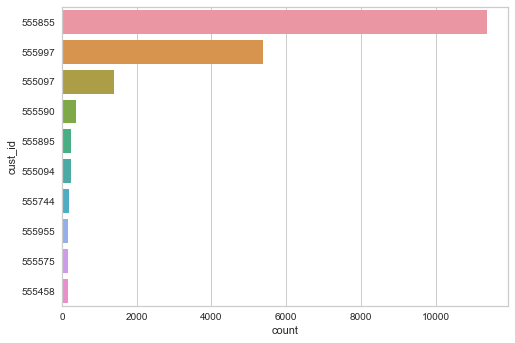

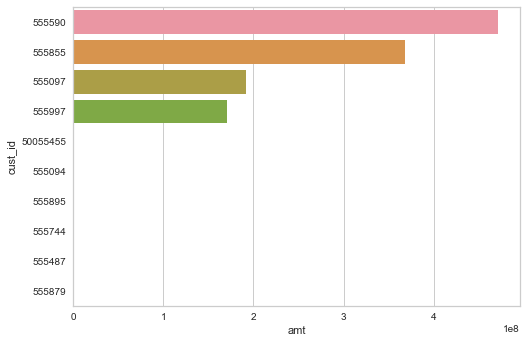

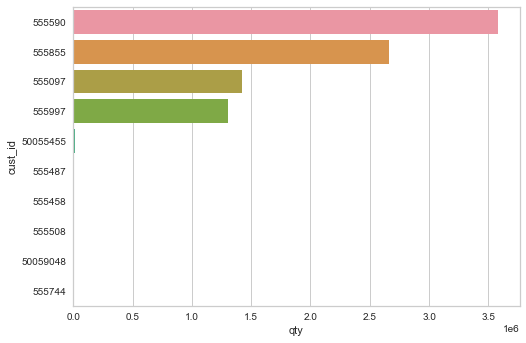

<Figure size 576x396 with 0 Axes>

In [15]:
# Show the number of data
sns.countplot(y=dfAggSKU['cust_id'], order=dfAggSKU['cust_id'].value_counts().iloc[:10].index)
plt.show()

sns.barplot(x="amt", y="cust_id", data=dfAggSKU.groupby(['cust_id']).agg({'amt': sum}).sort_values(by='amt', ascending=False).reset_index().head(10))
plt.show()

sns.barplot(x="qty", y="cust_id", data=dfAggSKU.groupby(['cust_id']).agg({'qty': sum}).sort_values(by='qty', ascending=False).reset_index().head(10))
plt.show()

plt.tight_layout()

qty      amt  acct_doc_nmbr  fscl_yr  fscl_mo  cmpny_id  deducAmt  \
count  25412    25412          25412    25412    25412     25412     25412   
mean     359    47666     6710237582     2020        6     66676    -22343   
std     1327   204307     1956340464        1        3     99315    106680   
min        1        8       53000000     2019        1     37492  -4031680   
25%       24     1099     7280077666     2019        3     37492    -13341   
50%       83     6554     7288007675     2020        6     37492      -418   
75%      260    31271     7288080657     2021        9     37492       -35   
max    36060  5674153     7288888888     2021       12    404637    143477   

       retailPrice   netAmt  
count        25412    25412  
mean           128    25323  
std             99   108765  
min              8  -368801  
25%             33      864  
50%            129     3676  
75%            224    16087  
max            417  3438860

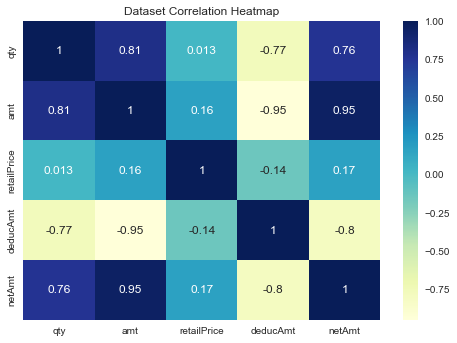

In [16]:
display(dfAggSKU.describe().apply(lambda s: s.apply(lambda x: round(x))))
sns.heatmap(dfAggSKU[['qty', 'amt', 'retailPrice', 'deducAmt', 'netAmt']].corr(), cmap="YlGnBu", annot=True).set(title='Dataset Correlation Heatmap')
plt.show()

# Customer Segmentation using RFM

In [17]:
# Extract relevant columns for RFM analysis
rfmDF = dfAggSKU[['acct_doc_nmbr', 'cust_id', 'pstng_dt', 'netAmt']].copy()
rfmDF['cust_id'] = rfmDF['cust_id'].astype('int64')
print(rfmDF.dtypes)
display(rfmDF)

# Get the latest date by finding the latest transaction date made + 1 day
print(rfmDF['pstng_dt'].min(), rfmDF['pstng_dt'].max())
latestDate = rfmDF['pstng_dt'].max() + dt.timedelta(days=1)
print(latestDate)

acct_doc_nmbr             int64
cust_id                   int64
pstng_dt         datetime64[ns]
netAmt                  float64
dtype: object


acct_doc_nmbr  cust_id   pstng_dt     netAmt
15736     7288005878   555590 2020-12-02 3438859.80
1194        53005240   555590 2021-03-29 1000739.85
24168     7288084456   555590 2020-10-29  935870.02
27604     7288837668   555590 2021-05-11 2189683.03
27092     7288825665   555590 2021-03-25 2108860.27
...              ...      ...        ...        ...
1467        53006280   555775 2021-04-09   -1679.85
10070     7280088058   555550 2019-12-17      10.37
9337      7280085354   555997 2019-12-30       8.76
196         53000483   555855 2021-02-08       7.45
11093     7280840063   555550 2019-01-25       7.07

[25412 rows x 4 columns]

2019-01-02 00:00:00 2021-12-29 00:00:00
2021-12-30 00:00:00


In [18]:
# display(rfmDF.groupby(['acct_doc_nmbr', 'cust_id', 'pstng_dt'], as_index=False).agg({'amt': 'mean', 'deducAmt': 'mean'}))
# display(rfmDF.groupby(['acct_doc_nmbr', 'cust_id', 'pstng_dt'], as_index=False).agg({'amt': 'sum', 'deducAmt': 'sum'}))
# rfmDF = rfmDF.groupby(['acct_doc_nmbr', 'cust_id', 'pstng_dt'], as_index=False).agg({'amt': 'sum', 'deducAmt': 'sum'})
# rfmDF['netAmt'] = rfmDF['amt'] + rfmDF['deducAmt']
# rfmDF

In [19]:
# Recency, Frequency, Monetary
# Get the latest date of all cust_id transaction
# Get the total count of transaction made by each cust_id
# Get the total price amount of products made by each cust_id
rfmGrpDF = rfmDF.groupby('cust_id').agg({'pstng_dt': lambda date: (latestDate - date.max()).days,
                                        'acct_doc_nmbr': lambda num: num.count(),
                                        'netAmt': lambda price: price.sum()})

# Change the name of columns
rfmGrpDF.columns=['recency','frequency','monetary']
print(rfmGrpDF.dtypes)

# Change column datatypes
# rfmGrpDF = rfmGrpDF.astype({'frequency': np.int64, 'monetary': np.float64})
# print(rfmGrpDF.dtypes)
rfmGrpDF

recency        int64
frequency      int64
monetary     float64
dtype: object


recency  frequency     monetary
cust_id                                  
555094          2        231    138201.95
555097          2       1390 101561937.33
555099        268          1      1638.48
555404         10          2      3313.39
555405        302         23     10595.60
...           ...        ...          ...
50095780      217         23     33340.70
50095797       20         85     31550.06
50095799        8         39     36684.01
50095907       16         59     63977.13
50095908       17         27     45494.16

[199 rows x 3 columns]

In [20]:
# Add a constant value to make all values positive for boxcox transformation
print(rfmGrpDF.describe().apply(lambda s: s.apply(lambda x: round(x))))
if (rfmGrpDF['monetary'].min() < 0):
    rfmGrpDF['monetary'] += (-rfmGrpDF['monetary'].min() + 1)
print(rfmGrpDF.describe().apply(lambda s: s.apply(lambda x: round(x))))

       recency  frequency   monetary
count      199        199        199
mean       215        128    3233742
std        246        893   24441688
min          1          1    -157954
25%         22          3        840
50%        167         19       6942
75%        280         48      34315
max       1066      11374  251479139
       recency  frequency   monetary
count      199        199        199
mean       215        128    3391696
std        246        893   24441688
min          1          1          1
25%         22          3     158795
50%        167         19     164897
75%        280         48     192269
max       1066      11374  251637093


In [21]:
trfTestDF = rfmGrpDF.copy()

# Boxcox transformation for monteary that includes non-positive values
# https://www.isixsigma.com/tools-templates/normality/making-data-normal-using-box-cox-power-transformation/
# https://stackoverflow.com/questions/50180988/valueerror-data-must-be-positive-boxcox-scipy

trfTestDF[['rec_sqrt', 'freq_sqrt', 'money_sqrt']] = np.sqrt(trfTestDF[['recency', 'frequency', 'monetary']])

trfTestDF[['rec_log', 'freq_log', 'money_log']] = np.log1p(trfTestDF[['recency', 'frequency', 'monetary']])

trfTestDF['money_boxcox'] = stats.boxcox(trfTestDF['monetary'])[0]
trfTestDF['rec_boxcox'] = stats.boxcox(trfTestDF['recency'])[0]
trfTestDF['freq_boxcox'] = stats.boxcox(trfTestDF['frequency'])[0]
trfTestDF

recency  frequency     monetary  rec_sqrt  freq_sqrt  money_sqrt  \
cust_id                                                                      
555094          2        231    296156.63      1.41      15.20      544.20   
555097          2       1390 101719892.01      1.41      37.28    10085.63   
555099        268          1    159593.16     16.37       1.00      399.49   
555404         10          2    161268.07      3.16       1.41      401.58   
555405        302         23    168550.28     17.38       4.80      410.55   
...           ...        ...          ...       ...        ...         ...   
50095780      217         23    191295.38     14.73       4.80      437.37   
50095797       20         85    189504.74      4.47       9.22      435.32   
50095799        8         39    194638.69      2.83       6.24      441.18   
50095907       16         59    221931.81      4.00       7.68      471.10   
50095908       17         27    203448.83      4.12       5.20      451.05   

          rec_log  freq_log  money_log  money_boxcox  rec_boxcox  freq_boxcox  
cust_id                                                                        
555094       1.10      5.45      12.60         14.50        0.75         4.65  
555097       1.10      7.24      18.44         22.70        0.75         5.87  
555099       5.59      0.69      11.98         13.69       10.70         0.00  
555404       2.40      1.10      11.99         13.71        2.97         0.68  
555405       5.71      3.18      12.03         13.76       11.09         2.86  
...           ...       ...        ...           ...         ...          ...  
50095780     5.38      3.18      12.16         13.93       10.02         2.86  
50095797     3.04      4.45      12.15         13.92        4.18         3.90  
50095799     2.20      3.69      12.18         13.95        2.61         3.29  
50095907     2.83      4.09      12.31         14.12        3.77         3.62  
50095908     2.89      3.33      12.22         14.01        3.88         2.99  

[199 rows x 12 columns]

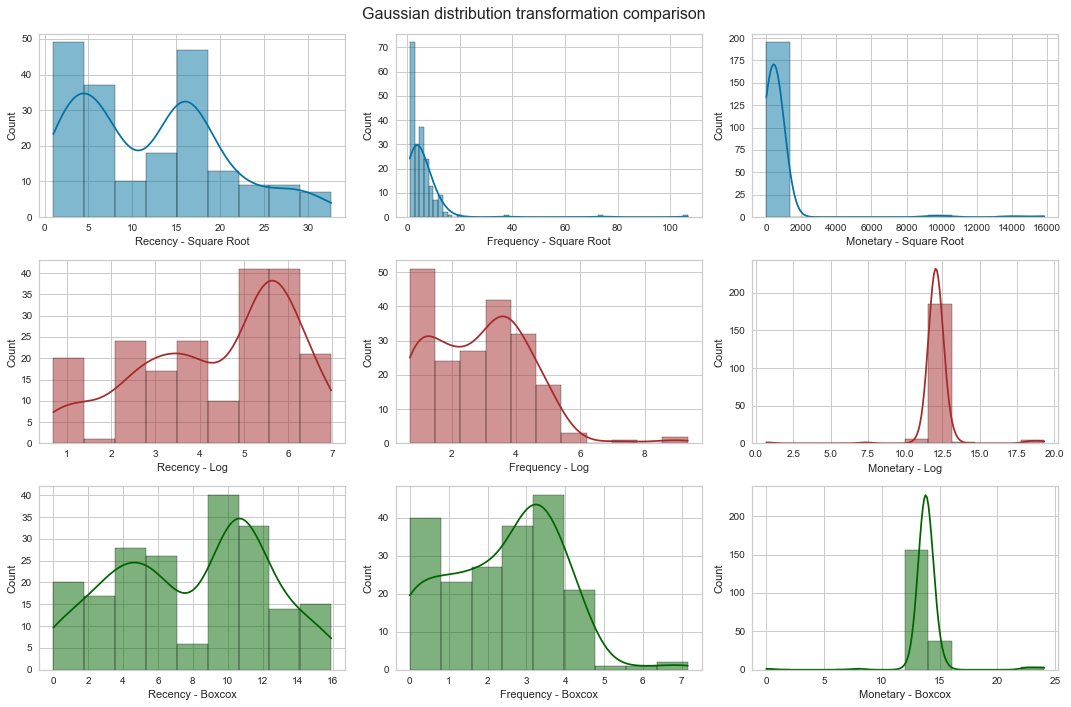

In [22]:
# Vizualise Skewness
plt.figure(figsize=(15, 10))
plt.suptitle("Gaussian distribution transformation comparison", fontsize=16)

plt.subplot(3, 3, 1)
sns.histplot(trfTestDF['rec_sqrt'], kde=True)
plt.xlabel("Recency - Square Root")
plt.subplot(3, 3, 2)
sns.histplot(trfTestDF['freq_sqrt'], kde=True)
plt.xlabel("Frequency - Square Root")
plt.subplot(3, 3, 3)
sns.histplot(trfTestDF['money_sqrt'], bins=12, kde=True)
plt.xlabel("Monetary - Square Root")

plt.subplot(3, 3, 4)
sns.histplot(trfTestDF['rec_log'], kde=True, color=['brown'])
plt.xlabel("Recency - Log")
plt.subplot(3, 3, 5)
sns.histplot(trfTestDF['freq_log'], kde=True, color=['brown'])
plt.xlabel("Frequency - Log")
plt.subplot(3, 3, 6)
sns.histplot(trfTestDF['money_log'], bins=12, kde=True, color=['brown'])
plt.xlabel("Monetary - Log")

plt.subplot(3, 3, 7)
sns.histplot(trfTestDF['rec_boxcox'], kde=True, color=['darkgreen'])
plt.xlabel("Recency - Boxcox")
plt.subplot(3, 3, 8)
sns.histplot(trfTestDF['freq_boxcox'], kde=True, color=['darkgreen'])
plt.xlabel("Frequency - Boxcox")
plt.subplot(3, 3, 9)
sns.histplot(trfTestDF['money_boxcox'], bins=12, kde=True, color=['darkgreen'])
plt.xlabel("Monetary - Boxcox")
plt.tight_layout()
# plt.savefig('RFM/rfm_gaussian_transformation.png')
plt.show()


In [23]:
# Measure Skewness
print(trfTestDF[['rec_sqrt', 'freq_sqrt', 'money_sqrt', 'rec_log', 'freq_log', 'money_log', 'rec_boxcox', 'freq_boxcox', 'money_boxcox']].skew())

# Measure Kurtosis
print(trfTestDF[['rec_sqrt', 'freq_sqrt', 'money_sqrt', 'rec_log', 'freq_log', 'money_log', 'rec_boxcox', 'freq_boxcox', 'money_boxcox']].kurt())

rec_sqrt        0.50
freq_sqrt       7.75
money_sqrt      7.40
rec_log        -0.56
freq_log        0.62
money_log      -0.91
rec_boxcox     -0.15
freq_boxcox     0.01
money_boxcox    0.36
dtype: float64
rec_sqrt       -0.61
freq_sqrt      72.13
money_sqrt     55.62
rec_log        -0.76
freq_log        1.08
money_log      40.48
rec_boxcox     -1.05
freq_boxcox    -0.33
money_boxcox   35.88
dtype: float64


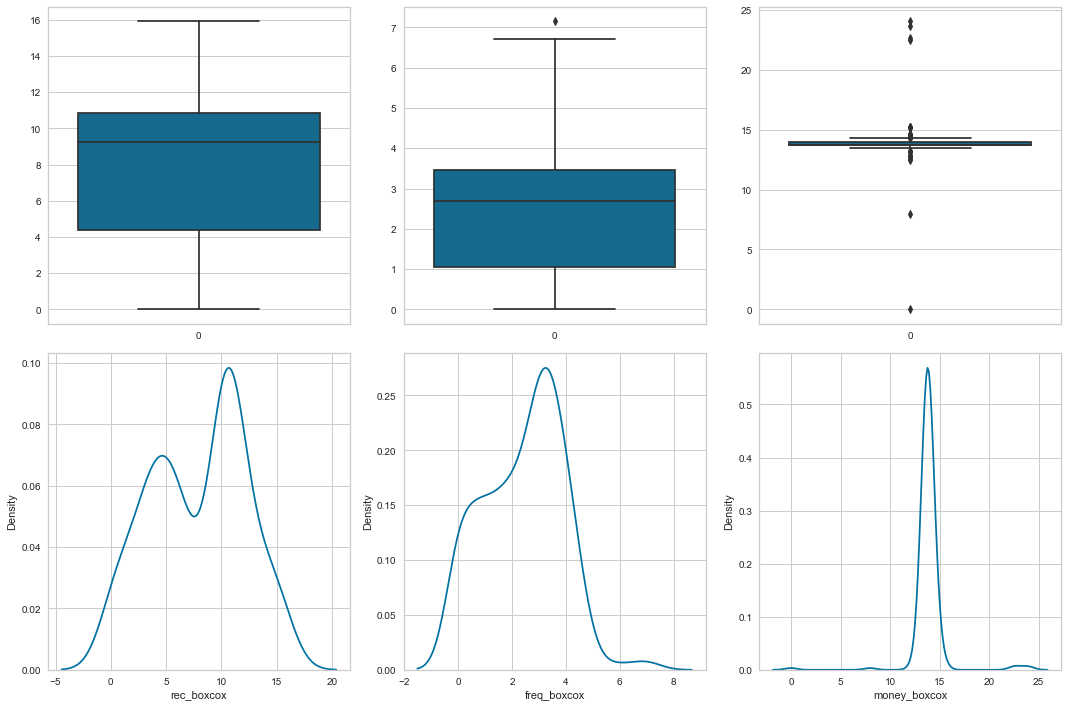

In [24]:
rfmGrpDF[['rec_boxcox', 'freq_boxcox', 'money_boxcox']] = trfTestDF[['rec_boxcox', 'freq_boxcox', 'money_boxcox']]
rfmGrpDF = rfmGrpDF.reset_index()

# Vizualise Outliers
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
sns.boxplot(data=rfmGrpDF['rec_boxcox'])
plt.subplot(2, 3, 2)
sns.boxplot(data=rfmGrpDF['freq_boxcox'])
plt.subplot(2, 3, 3)
sns.boxplot(data=rfmGrpDF['money_boxcox'])

plt.subplot(2, 3, 4)
sns.kdeplot(rfmGrpDF['rec_boxcox'])
plt.subplot(2, 3, 5)
sns.kdeplot(rfmGrpDF['freq_boxcox'])
plt.subplot(2, 3, 6)
sns.kdeplot(rfmGrpDF['money_boxcox'])
plt.tight_layout()
plt.show()

In [25]:
# Standardize data
sdScaler = preprocessing.StandardScaler()
rfmGrpDF[['rec_sdScaled', 'freq_sdScaled', 'money_sdScaled']] = sdScaler.fit_transform(rfmGrpDF[['rec_boxcox', 'freq_boxcox', 'money_boxcox']])

mmScaler = preprocessing.MinMaxScaler()
rfmGrpDF[['rec_mmScaled', 'freq_mmScaled', 'money_mmScaled']] = mmScaler.fit_transform(rfmGrpDF[['rec_boxcox', 'freq_boxcox', 'money_boxcox']])

rfmGrpDF

cust_id  recency  frequency     monetary  rec_boxcox  freq_boxcox  \
0      555094        2        231    296156.63        0.75         4.65   
1      555097        2       1390 101719892.01        0.75         5.87   
2      555099      268          1    159593.16       10.70         0.00   
3      555404       10          2    161268.07        2.97         0.68   
4      555405      302         23    168550.28       11.09         2.86   
..        ...      ...        ...          ...         ...          ...   
194  50095780      217         23    191295.38       10.02         2.86   
195  50095797       20         85    189504.74        4.18         3.90   
196  50095799        8         39    194638.69        2.61         3.29   
197  50095907       16         59    221931.81        3.77         3.62   
198  50095908       17         27    203448.83        3.88         2.99   

     money_boxcox  rec_sdScaled  freq_sdScaled  money_sdScaled  rec_mmScaled  \
0           14.50         -1.68           1.53            0.33          0.05   
1           22.70         -1.68           2.37            5.03          0.05   
2           13.69          0.65          -1.66           -0.13          0.67   
3           13.71         -1.16          -1.19           -0.12          0.19   
4           13.76          0.74           0.30           -0.09          0.70   
..            ...           ...            ...             ...           ...   
194         13.93          0.49           0.30            0.00          0.63   
195         13.92         -0.88           1.02           -0.00          0.26   
196         13.95         -1.24           0.60            0.02          0.16   
197         14.12         -0.97           0.82            0.12          0.24   
198         14.01         -0.95           0.39            0.05          0.24   

     freq_mmScaled  money_mmScaled  
0             0.65            0.60  
1             0.82            0.94  
2             0.00            0.57  
3             0.09            0.57  
4             0.40            0.57  
..             ...             ...  
194           0.40            0.58  
195           0.55            0.58  
196           0.46            0.58  
197           0.51            0.59  
198           0.42            0.58  

[199 rows x 13 columns]

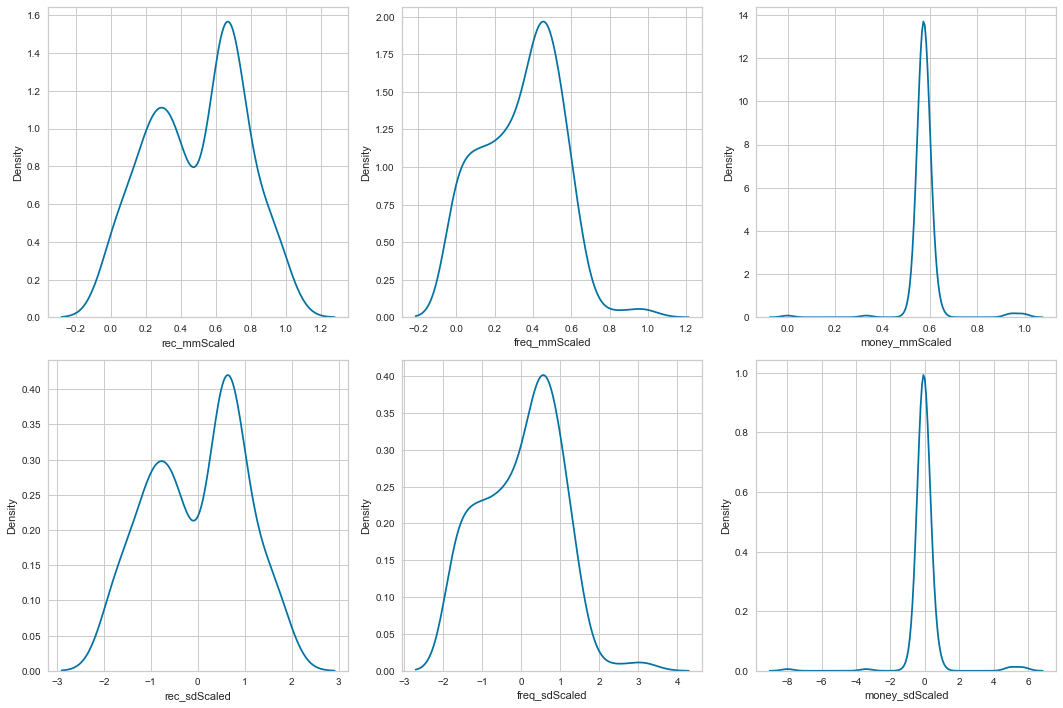

In [26]:
# Vizualise Outliers
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
sns.kdeplot(rfmGrpDF['rec_mmScaled'])
plt.subplot(2, 3, 2)
sns.kdeplot(rfmGrpDF['freq_mmScaled'])
plt.subplot(2, 3, 3)
sns.kdeplot(rfmGrpDF['money_mmScaled'])

plt.subplot(2, 3, 4)
sns.kdeplot(rfmGrpDF['rec_sdScaled'])
plt.subplot(2, 3, 5)
sns.kdeplot(rfmGrpDF['freq_sdScaled'])
plt.subplot(2, 3, 6)
sns.kdeplot(rfmGrpDF['money_sdScaled'])
plt.tight_layout()
plt.show()

In [27]:
# Prepare dataframe for clustering
kRFM = pd.DataFrame().assign(rec=rfmGrpDF['rec_sdScaled'], freq=rfmGrpDF['freq_sdScaled'], money=rfmGrpDF['money_sdScaled'])
kRFM = kRFM.reset_index(drop=True)

In [28]:
pd.reset_option("all")
pd.set_option('display.max_columns', None)

dfRFMSilScore = pd.DataFrame(columns=['ClusterSize','KMeansSS', 'SpectralClusteringSS','AgglomerativeClusteringSS'])
dfRFMCHScore = pd.DataFrame(columns=['ClusterSize', 'KMeansCH', 'SpectralClusteringCH', 'AgglomerativeClusteringCH'])
dfRFMDBScore = pd.DataFrame(columns=['ClusterSize', 'KMeansDB', 'SpectralClusteringDB', 'AgglomerativeClusteringDB'])
dfRFMTime = pd.DataFrame(columns=['ClusterSize', 'KMeansTime', 'SpectralClusteringTime', 'AgglomerativeClusteringTime'])

# Evaluate models
for i in range(2, 11):
    tempSilScore = {'ClusterSize':i}
    tempCHScore = {'ClusterSize':i}
    tempDBScore = {'ClusterSize':i}
    tempTime = {'ClusterSize':i}
    
    start_time = time.time()
    tempSilScore['KMeansSS'] = silhouette_score(kRFM, KMeans(n_clusters=i,
         random_state=42).fit_predict(kRFM))
    tempCHScore['KMeansCH'] = calinski_harabasz_score(kRFM, KMeans(n_clusters=i,
         random_state=42).fit_predict(kRFM))
    tempDBScore['KMeansDB'] = davies_bouldin_score(kRFM, KMeans(n_clusters=i,
         random_state=42).fit_predict(kRFM))
    tempTime['KMeansTime'] = round(time.time() - start_time, 3)
    
    start_time = time.time()
    tempSilScore['SpectralClusteringSS'] = silhouette_score(kRFM, SpectralClustering(n_clusters=i,
         assign_labels='discretize', random_state=42).fit_predict(kRFM))
    tempCHScore['SpectralClusteringCH'] = calinski_harabasz_score(kRFM, SpectralClustering(n_clusters=i,
         assign_labels='discretize', random_state=42).fit_predict(kRFM))
    tempDBScore['SpectralClusteringDB'] = davies_bouldin_score(kRFM, SpectralClustering(n_clusters=i,
         assign_labels='discretize', random_state=42).fit_predict(kRFM))
    tempTime['SpectralClusteringTime'] = round(time.time() - start_time, 3)
    
    start_time = time.time()
    tempSilScore['AgglomerativeClusteringSS'] = silhouette_score(kRFM, AgglomerativeClustering(n_clusters=i).fit_predict(kRFM))
    tempCHScore['AgglomerativeClusteringCH'] = calinski_harabasz_score(kRFM, AgglomerativeClustering(n_clusters=i).fit_predict(kRFM))
    tempDBScore['AgglomerativeClusteringDB'] = davies_bouldin_score(kRFM, AgglomerativeClustering(n_clusters=i,).fit_predict(kRFM))
    tempTime['AgglomerativeClusteringTime'] = round(time.time() - start_time, 3)
    
    dfRFMSilScore = pd.concat([dfRFMSilScore, pd.DataFrame([tempSilScore])])
    dfRFMCHScore = pd.concat([dfRFMCHScore, pd.DataFrame([tempCHScore])])
    dfRFMDBScore = pd.concat([dfRFMDBScore, pd.DataFrame([tempDBScore])])
    dfRFMTime = pd.concat([dfRFMTime, pd.DataFrame([tempTime])])
    
    
display(dfRFMSilScore.reset_index(drop=True))
display(dfRFMCHScore.reset_index(drop=True))
display(dfRFMDBScore.reset_index(drop=True))

print("Silhouette score (Higher is better):")
print(round(dfRFMSilScore[['KMeansSS', 'SpectralClusteringSS','AgglomerativeClusteringSS']].mean(), 3))
print("Calinski-Harabasz score (Higher is better):")
print(round(dfRFMCHScore[['KMeansCH', 'SpectralClusteringCH', 'AgglomerativeClusteringCH']].mean(), 3))
print("Davies-Bouldin score (Lower is better):")
print(round(dfRFMDBScore[['KMeansDB', 'SpectralClusteringDB', 'AgglomerativeClusteringDB']].mean(), 3))

C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\pandas\_config\config.py:645: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\pandas\_config\config.py:645: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


ClusterSize  KMeansSS SpectralClusteringSS AgglomerativeClusteringSS
0           2  0.478825             0.726501                  0.462083
1           3  0.502607             0.506124                  0.483519
2           4  0.506701              0.42754                  0.486566
3           5   0.43955             0.463345                  0.432489
4           6  0.485341             0.358542                  0.480205
5           7  0.433729             0.390398                  0.430041
6           8  0.432821             0.374575                  0.429151
7           9  0.397701             0.391594                  0.379152
8          10  0.402495             0.398013                  0.381815

ClusterSize    KMeansCH SpectralClusteringCH AgglomerativeClusteringCH
0           2  142.218383            69.985281                130.124481
1           3  170.400934           169.567354                 154.81335
2           4  185.582591           168.989007                166.327542
3           5  234.526662           153.185726                216.093708
4           6  248.061577           135.425057                 240.95177
5           7  265.194194           129.176941                241.943793
6           8  276.051392           117.565037                248.076221
7           9  298.533931           256.102356                261.315157
8          10  315.301714           264.620807                281.194998

ClusterSize  KMeansDB SpectralClusteringDB AgglomerativeClusteringDB
0           2  0.813925             0.308501                  0.843441
1           3  0.583722             0.577528                   0.58927
2           4  0.439924             0.696386                  0.542278
3           5  0.568877              0.61545                  0.663508
4           6   0.50691              0.92649                  0.613423
5           7  0.677293             0.874306                    0.6861
6           8   0.55117             0.846005                  0.560951
7           9  0.626794             0.673908                  0.612287
8          10  0.622698             0.689301                  0.620257

Silhouette score (Higher is better):
KMeansSS                     0.453
SpectralClusteringSS         0.449
AgglomerativeClusteringSS    0.441
dtype: float64
Calinski-Harabasz score (Higher is better):
KMeansCH                     237.319
SpectralClusteringCH         162.735
AgglomerativeClusteringCH    215.649
dtype: float64
Davies-Bouldin score (Lower is better):
KMeansDB                     0.599
SpectralClusteringDB         0.690
AgglomerativeClusteringDB    0.637
dtype: float64


In [29]:
dfRFMSilScore

ClusterSize  KMeansSS SpectralClusteringSS AgglomerativeClusteringSS
0           2  0.478825             0.726501                  0.462083
0           3  0.502607             0.506124                  0.483519
0           4  0.506701              0.42754                  0.486566
0           5   0.43955             0.463345                  0.432489
0           6  0.485341             0.358542                  0.480205
0           7  0.433729             0.390398                  0.430041
0           8  0.432821             0.374575                  0.429151
0           9  0.397701             0.391594                  0.379152
0          10  0.402495             0.398013                  0.381815

C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


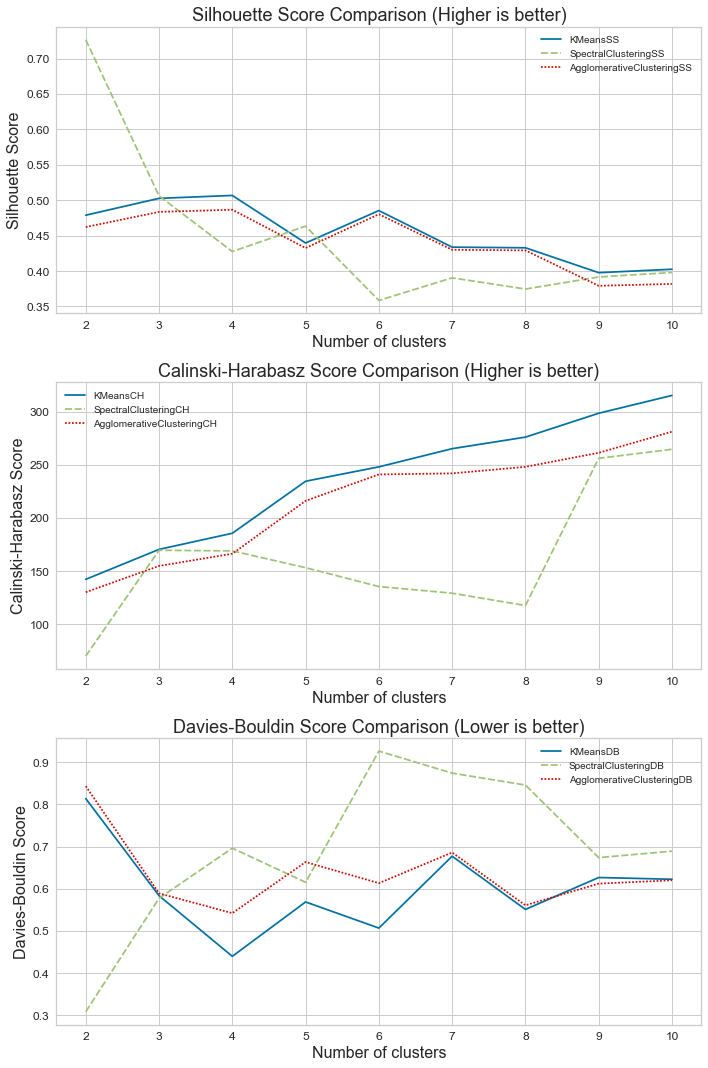

In [30]:
# sns.lineplot(data=dfRFMSilScore.set_index('ClusterSize'))
# , figsize=(20, 12)
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
a = sns.lineplot(data=dfRFMSilScore.set_index('ClusterSize'), ax=ax[0])
a.set_title('Silhouette Score Comparison (Higher is better)', fontsize=18)
a.set_ylabel('Silhouette Score', fontsize=16)
a.set_xlabel('Number of clusters', fontsize=16)
a.tick_params(labelsize=12)

b = sns.lineplot(data=dfRFMCHScore.set_index('ClusterSize'), ax=ax[1])
b.set_title('Calinski-Harabasz Score Comparison (Higher is better)', fontsize=18)
b.set_ylabel('Calinski-Harabasz Score', fontsize=16)
b.set_xlabel('Number of clusters', fontsize=16)
b.tick_params(labelsize=12)

c = sns.lineplot(data=dfRFMDBScore.set_index('ClusterSize'), ax=ax[2])
c.set_title('Davies-Bouldin Score Comparison (Lower is better)', fontsize=18)
c.set_ylabel('Davies-Bouldin Score', fontsize=16)
c.set_xlabel('Number of clusters', fontsize=16)
c.tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('RFM/evaluation_metrics.png')
plt.show()

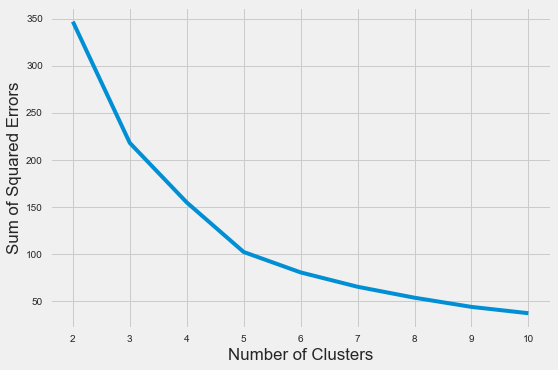

In [31]:
# A list holds theSum of Squared Errors for each k
sse = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(kRFM)
    sse.append(kmeans.inertia_)
    # score = silhouette_score(kRFM, kmeans.labels_)
    # sil_coeff.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Errors")
plt.show()

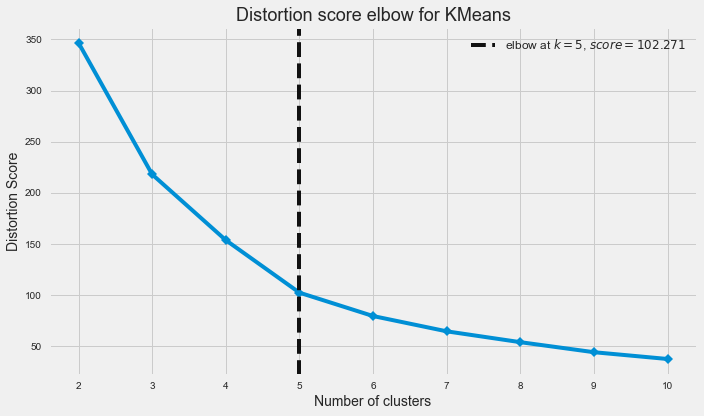

In [32]:
plt.figure(figsize=(10, 6))
# Using yellowbrick library to visualize elbow point for selected clustering model
km = KMeans()
visualizer = KElbowVisualizer(km, k=(2,11), timings=False)
visualizer.fit(kRFM)
# visualizer.show()
plt.title('Distortion score elbow for KMeans', fontsize=18)
plt.ylabel('Distortion Score', fontsize=14)
plt.xlabel('Number of clusters', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.tight_layout()
# plt.savefig("RFM/elbow_plot.png")
plt.show()


# fig, ax = plt.subplots(3, 1, figsize=(10, 15))
# a = sns.lineplot(data=dfRFMSilScore.set_index('ClusterSize'), ax=ax[0])
# a.set_title('Silhouette Score Comparison (Higher is better)', fontsize=18)
# a.set_ylabel('Silhouette Score', fontsize=16)
# a.set_xlabel('Number of clusters', fontsize=16)
# a.tick_params(labelsize=12)

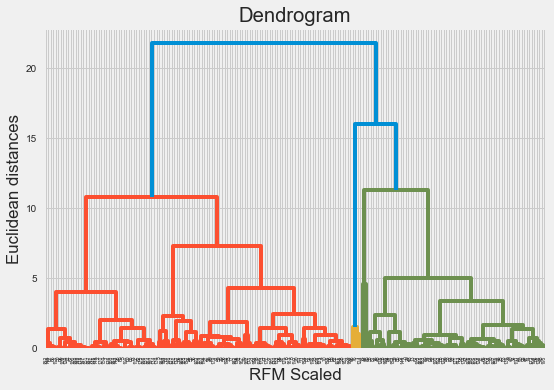

In [33]:
# Dendogram visualization
dendrogram = sch.dendrogram(sch.linkage(kRFM, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('RFM Scaled')
plt.ylabel('Euclidean distances')
plt.show()

In [34]:
# KMeans clustering of x clusters fitted to the normalized dataset
kmCluster = KMeans(n_clusters=5)
kmCluster.fit(kRFM)

# Extract cluster labels and insert into dataframe
cluster_lbl = kmCluster.labels_
rfmGrpDF['prediction'] = cluster_lbl

# k3RFM = rfm.assign(cluster3_lbl=cluster_lbl)
rfmClusterAvg = rfmGrpDF.groupby('prediction').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(2)

rfmClusterAvg

recency frequency      monetary      
              mean      mean          mean count
prediction                                      
0            24.13     69.59  2.073110e+05    78
1           249.60     17.95  1.797844e+05    62
2            16.50    122.00  7.804200e+02     2
3             1.50   4631.25  1.598093e+08     4
4           478.72      1.92  1.583351e+05    53

In [35]:
# Melt the standardized dataset and reset the index
rfmMelt = pd.melt(
    rfmGrpDF.reset_index(),     
    id_vars = ['cust_id', 'prediction'],
                value_vars = ['rec_sdScaled', 'freq_sdScaled', 'money_sdScaled'], 
                var_name = 'metric', 
                value_name = 'value'
)
rfmMelt

cust_id  prediction          metric     value
0      555094           0    rec_sdScaled -1.680203
1      555097           3    rec_sdScaled -1.680203
2      555099           4    rec_sdScaled  0.648897
3      555404           0    rec_sdScaled -1.160564
4      555405           1    rec_sdScaled  0.741261
..        ...         ...             ...       ...
592  50095780           1  money_sdScaled  0.004320
593  50095797           0  money_sdScaled -0.002710
594  50095799           0  money_sdScaled  0.017276
595  50095907           0  money_sdScaled  0.115561
596  50095908           0  money_sdScaled  0.050402

[597 rows x 4 columns]

Text(0, 0.5, 'Value')

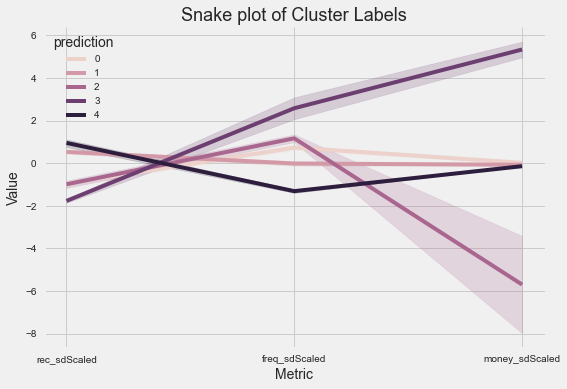

In [36]:
plot = sns.lineplot(data=rfmMelt, x='metric', y='value', hue='prediction')
sns.despine(left=False, bottom=False)
plot.set_title('Snake plot of Cluster Labels', fontsize = 18)
plot.set_xlabel('Metric', fontsize = 14)
plot.set_ylabel('Value', fontsize = 14)

In [37]:
# # Calculate relative importance of each attribute
# # Calculate average RFM values for each cluster
rfmMean = rfmGrpDF.groupby(['prediction'])[['rec_sdScaled', 'freq_sdScaled', 'money_sdScaled']].mean() 
print(rfmMean)

# # Calculate average RFM values for the total population
# totalMean = k3RFM_mean.mean()
# print(totalMean)

# # Calculate relative importance of cluster's attribute value compared to population
# relImpK3 = k3RFM_mean / (totalMean - 1)

# # relImpK3 = relImpK3.reindex([0, 2, 1])
# # relImpK3 = relImpK3.rename(index={}).sort_index()

# # Print relative importance score rounded to 2 decimals
# print(relImpK3.round(2))

            rec_sdScaled  freq_sdScaled  money_sdScaled
prediction                                             
0              -0.959040       0.737707        0.020970
1               0.535559      -0.012867       -0.069553
2              -0.987097       1.171259       -5.695300
3              -1.767576       2.584283        5.341714
4               0.955564      -1.309869       -0.137728


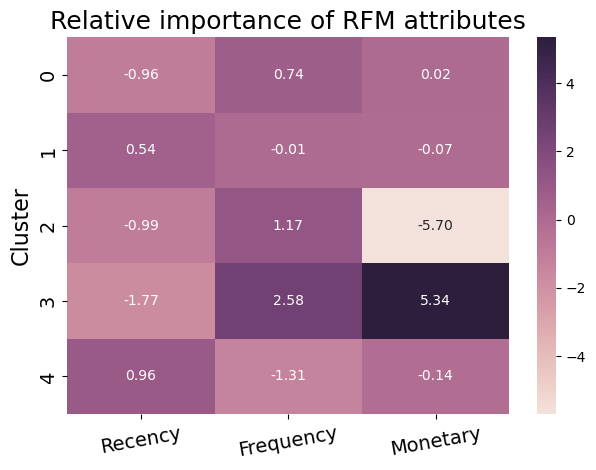

In [38]:
mpl.rcParams.update(mpl.rcParamsDefault)
cmap = sns.cubehelix_palette(light=0.9, as_cmap=True)
plot = sns.heatmap(data=rfmMean, annot=True, fmt='.2f', 
                   cmap=cmap, xticklabels=["Recency", "Frequency", "Monetary"]) 
plot.set_title('Relative importance of RFM attributes', fontsize=18)
plot.tick_params(axis='both', labelsize=14)
plot.set_ylabel('Cluster', fontsize=16)
# plot.set_xlabel("test")
plt.xticks(rotation=10)
plt.tight_layout()
# plt.savefig("RFM/rfm_importance.png")
plt.show()

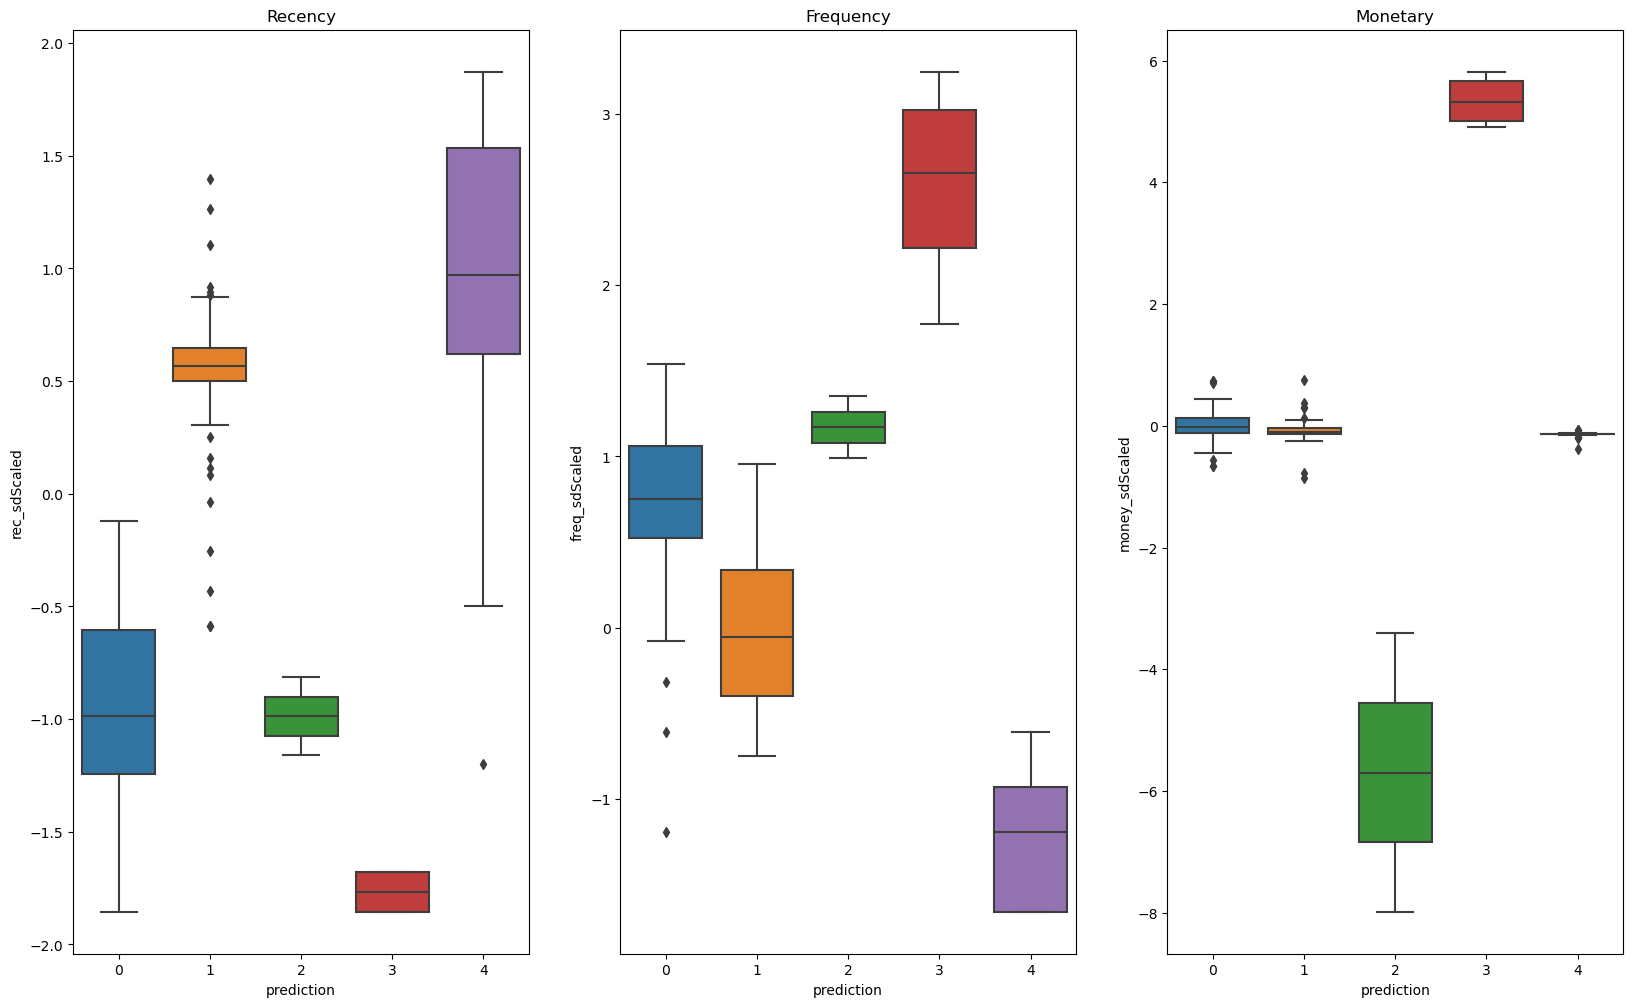

In [39]:
# cluster comparison on recency, frequency, and monetary
rfmResult = pd.DataFrame()
rfmResult = rfmGrpDF[["cust_id", 'recency', 'frequency', 'monetary', 'rec_sdScaled', 'freq_sdScaled', 'money_sdScaled', "prediction"]]
rfmResult = rfmResult.set_index("cust_id").sort_values(by=['prediction'])

fig, ax = plt.subplots(1, 3, figsize=(20, 12))
sns.boxplot(x='prediction', y='rec_sdScaled', data=rfmResult, ax=ax[0]).set(title='Recency')
sns.boxplot(x='prediction', y='freq_sdScaled', data=rfmResult, ax=ax[1]).set(title='Frequency')
sns.boxplot(x='prediction', y='money_sdScaled', data=rfmResult, ax=ax[2]).set(title='Monetary')
plt.show()

<AxesSubplot:xlabel='freq_sdScaled', ylabel='money_sdScaled'>

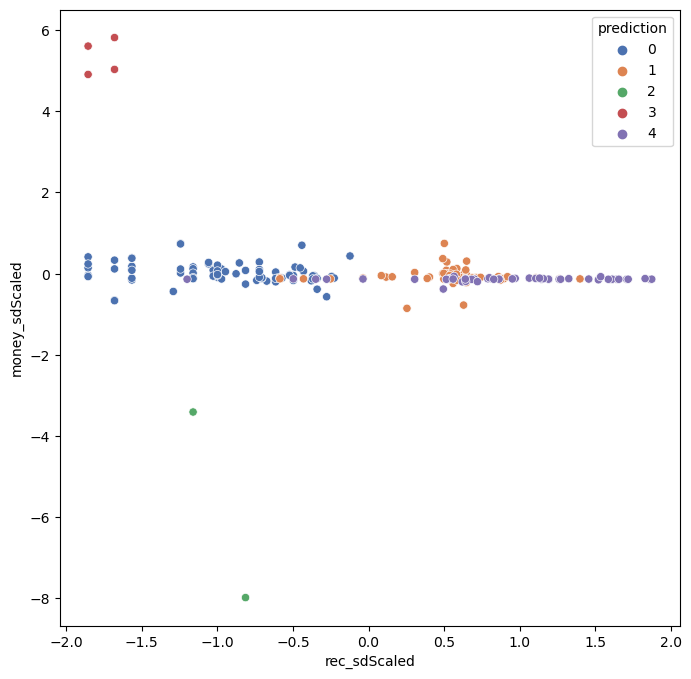

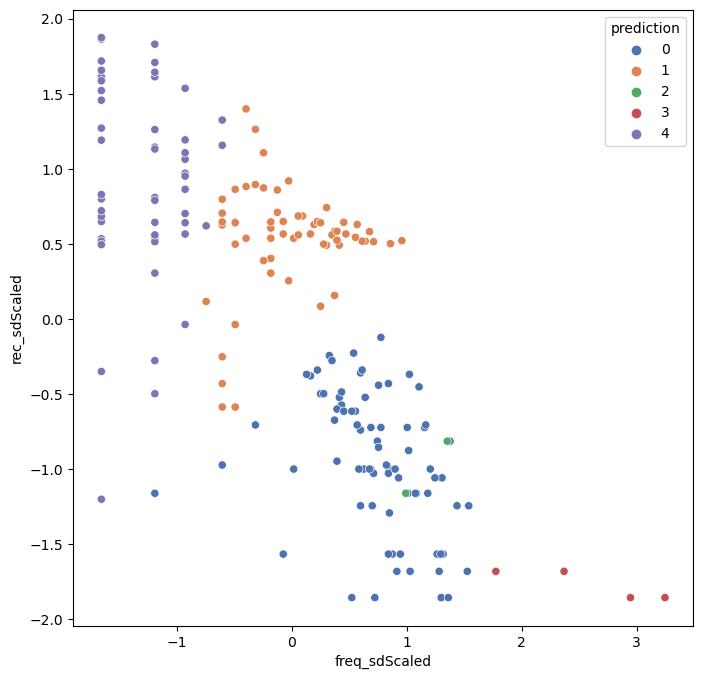

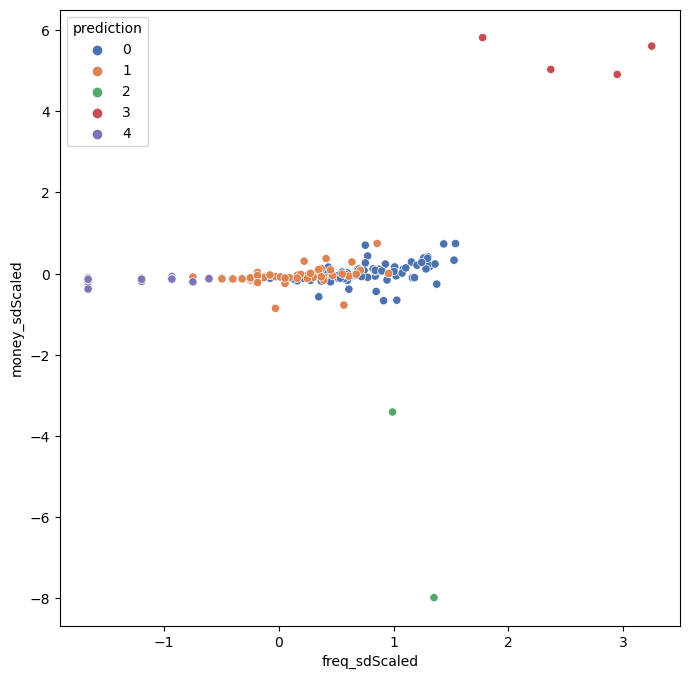

In [40]:
# Monetary vs Rrequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='rec_sdScaled', y='money_sdScaled', 
                data=rfmResult, 
                hue='prediction', 
                palette="deep")

# Frequency vs Recency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='freq_sdScaled', y='rec_sdScaled', 
                data=rfmResult, 
                hue='prediction', 
                palette="deep")

# Frequency vs Monetary (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='freq_sdScaled', y='money_sdScaled', 
                data=rfmResult, 
                hue='prediction', 
                palette="deep")

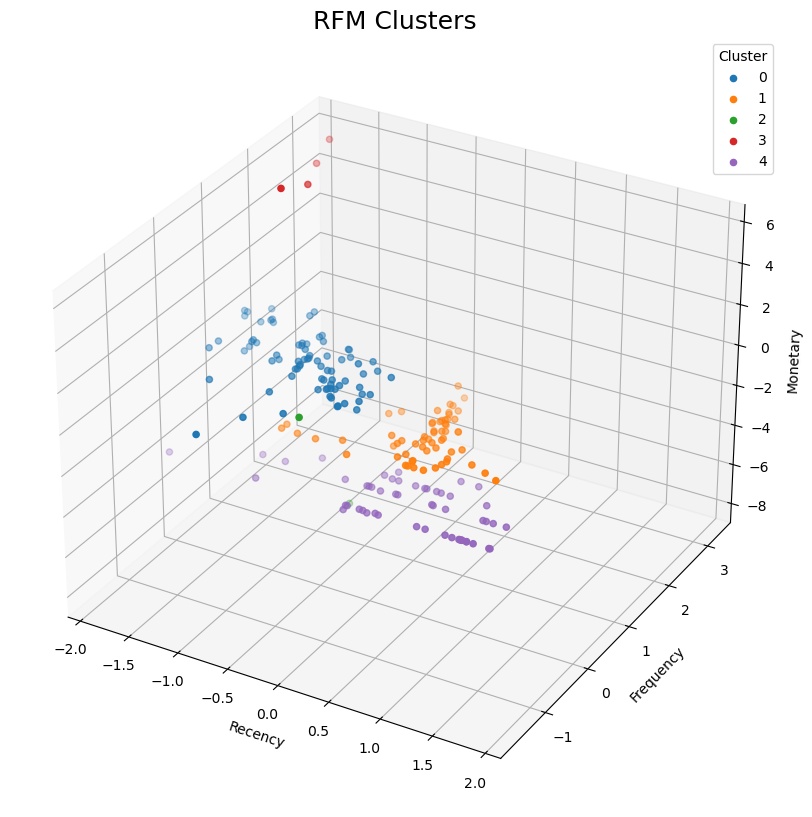

In [41]:
# 3d plot of RFM result
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection = '3d')

# x = rfmResult[rfmResult['rec_sdScaled']]
# y = rfmResult['freq_sdScaled']
# z = rfmResult['money_sdScaled']

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

for s in rfmResult['prediction'].unique():
    ax.scatter(rfmResult[rfmResult['prediction'] == s]['rec_sdScaled'], 
               rfmResult[rfmResult['prediction'] == s]['freq_sdScaled'], 
               rfmResult[rfmResult['prediction'] == s]['money_sdScaled'],
              label=s)
ax.legend(title="Cluster")
plt.title("RFM Clusters", fontsize=18)
# plt.tight_layout()
# plt.savefig('RFM/rfm_clusters.png')
plt.show()

In [42]:
rfmResult['prediction'].unique()

array([0, 1, 2, 3, 4])

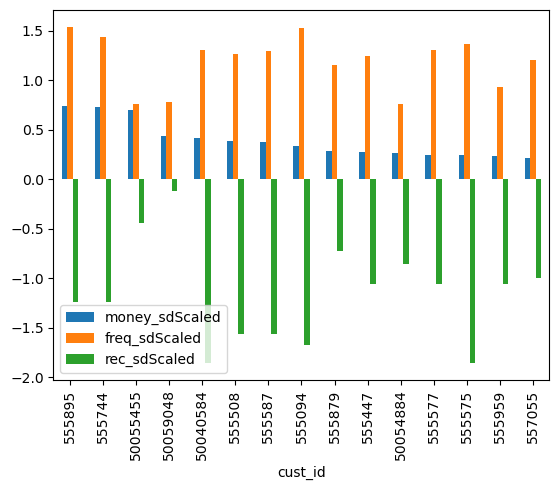

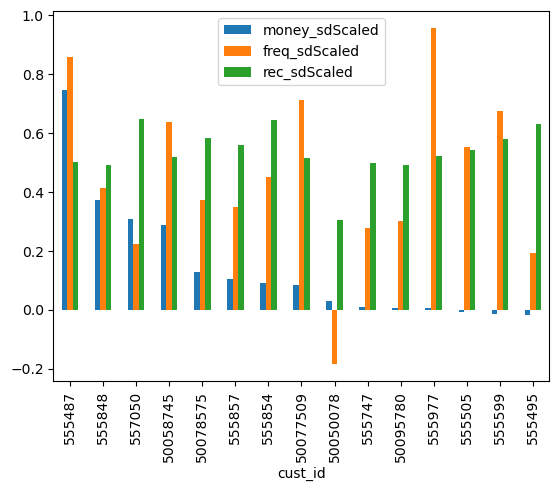

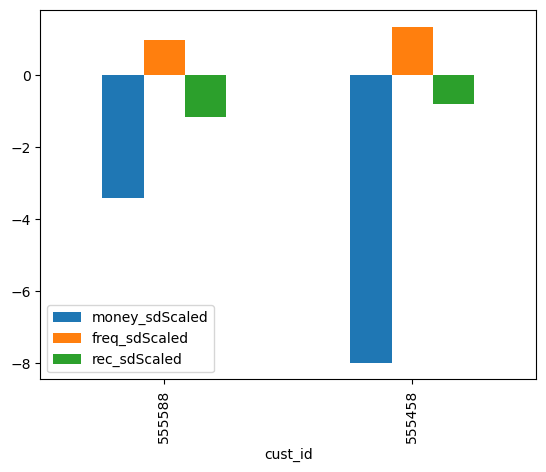

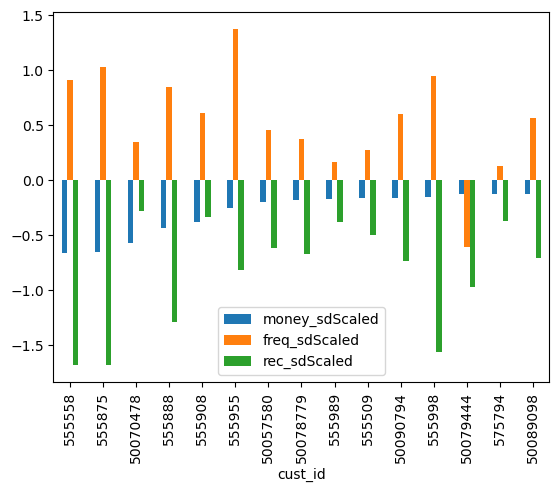

In [43]:
# selecting rows based on condition
firstRFM = rfmResult[rfmResult['prediction'] == 0][['money_sdScaled', 'freq_sdScaled', 'rec_sdScaled']].sort_values(['money_sdScaled', 'freq_sdScaled', 'rec_sdScaled'], ascending=[False, False, True])
# topRFM
firstRFM.head(15).plot.bar()
plt.show()

# selecting rows based on condition
secondRFM = rfmResult[rfmResult['prediction'] == 1][['money_sdScaled', 'freq_sdScaled', 'rec_sdScaled']].sort_values(['money_sdScaled', 'freq_sdScaled', 'rec_sdScaled'], ascending=[False, False, True])
# topRFM
secondRFM.head(15).plot.bar()
plt.show()

# selecting rows based on condition
thirdRFM = rfmResult[rfmResult['prediction'] == 2][['money_sdScaled', 'freq_sdScaled', 'rec_sdScaled']].sort_values(['money_sdScaled', 'freq_sdScaled', 'rec_sdScaled'], ascending=[False, False, True])
# topRFM
thirdRFM.head(15).plot.bar()
plt.show()

# selecting rows based on condition
worstRFM = rfmResult[rfmResult['prediction'] == 0][['money_sdScaled', 'freq_sdScaled', 'rec_sdScaled']].sort_values(['money_sdScaled', 'freq_sdScaled', 'rec_sdScaled'], ascending=[True, True, False])
# topRFM
worstRFM.head(15).plot.bar()
plt.show()

# Net Sales Demand Forecasting using Time series forecasting
## Average monthly sales demand forecasting

In [44]:
dfAggSKU

pk_sku2      qty           amt  \
15736  7288005878Drug_337492202012555590  23865.0  5.674153e+06   
1194    53005240Drug_1404637202103555590  36060.0  5.032420e+06   
24168  7288084456Drug_137492202010555590  29425.0  4.137322e+06   
27604  7288837668Drug_337492202105555590  16380.0  3.805952e+06   
27092  7288825665Drug_337492202103555590  15525.0  3.684334e+06   
...                                  ...      ...           ...   
1467    53006280Drug_1404637202104555775      1.0  1.621045e+01   
10070  7280088058Drug_237492201912555550      1.0  1.220496e+01   
9337   7280085354Drug_237492201912555997      1.0  8.859199e+00   
196     53000483Drug_2404637202102555855      1.0  7.539744e+00   
11093  7280840063Drug_237492201901555550      1.0  7.539744e+00   

       acct_doc_nmbr  fscl_yr  fscl_mo fscl_yr_mo  cmpny_id prod_name  \
15736     7288005878     2020       12 2020-12-01     37492    Drug_3   
1194        53005240     2021        3 2021-03-01    404637    Drug_1   
24168     7288084456     2020       10 2020-10-01     37492    Drug_1   
27604     7288837668     2021        5 2021-05-01     37492    Drug_3   
27092     7288825665     2021        3 2021-03-01     37492    Drug_3   
...              ...      ...      ...        ...       ...       ...   
1467        53006280     2021        4 2021-04-01    404637    Drug_1   
10070     7280088058     2019       12 2019-12-01     37492    Drug_2   
9337      7280085354     2019       12 2019-12-01     37492    Drug_2   
196         53000483     2021        2 2021-02-01    404637    Drug_2   
11093     7280840063     2019        1 2019-01-01     37492    Drug_2   

            cust_group cust_id     cust_name   pstng_dt  \
15736    MISCELLANEOUS  555590   Customer_12 2020-12-02   
1194     MISCELLANEOUS  555590   Customer_12 2021-03-29   
24168    MISCELLANEOUS  555590   Customer_12 2020-10-29   
27604    MISCELLANEOUS  555590   Customer_12 2021-05-11   
27092    MISCELLANEOUS  555590   Customer_12 2021-03-25   
...                ...     ...           ...        ...   
1467          HOSPITAL  555775  Customer_403 2021-04-09   
10070         HOSPITAL  555550  Customer_259 2019-12-17   
9337     MISCELLANEOUS  555997    Customer_8 2019-12-30   
196      MISCELLANEOUS  555855    Customer_2 2021-02-08   
11093  RETAIL_PHARMACY  555550  Customer_178 2019-01-25   

                            pk_sku      deducAmt  retailPrice        netAmt  
15736  7288005878Drug_337492202012 -2.235293e+06       237.76  3.438860e+06  
1194    53005240Drug_1404637202103 -4.031680e+06       139.56  1.000740e+06  
24168  7288084456Drug_137492202010 -3.201452e+06       140.61  9.358700e+05  
27604  7288837668Drug_337492202105 -1.616269e+06       232.35  2.189683e+06  
27092  7288825665Drug_337492202103 -1.575473e+06       237.32  2.108860e+06  
...                            ...           ...          ...           ...  
1467    53006280Drug_1404637202104 -1.696065e+03        16.21 -1.679855e+03  
10070  7280088058Drug_237492201912 -1.837813e+00        12.20  1.036715e+01  
9337   7280085354Drug_237492201912 -9.424680e-02         8.86  8.764952e+00  
196     53000483Drug_2404637202102 -9.424680e-02         7.54  7.445497e+00  
11093  7280840063Drug_237492201901 -4.712340e-01         7.54  7.068510e+00  

[25412 rows x 17 columns]

In [45]:
dfTSAll = dfAggSKU.copy()
dfTSAll['id'] = dfTSAll['cust_id'].astype(str) + "_" + dfTSAll['prod_name']
dfTSAll = dfTSAll.groupby(['id', 'fscl_yr_mo'], as_index=False).agg({'netAmt':'mean', 'amt':'mean', 'qty':'mean', 'retailPrice':'mean', 'deducAmt':'mean'})
# dfTSAll['fscl_yr_mo'] = dfTSAll['fscl_yr_mo'].astype('str') + "01"
# dfTSAll['fscl_yr_mo'] = pd.to_datetime(dfTSAll['fscl_yr_mo'])
display(dfTSAll)

id fscl_yr_mo        netAmt           amt    qty  \
0     50004940_Drug_2 2019-08-01    116.960279    290.280144    5.0   
1     50009595_Drug_2 2019-11-01   4587.038879   4605.369882  140.0   
2     50009595_Drug_3 2019-04-01   9373.409745  10133.415940   30.0   
3     50009595_Drug_3 2019-12-01    290.562884    314.124584    1.0   
4     50040584_Drug_2 2019-01-01   1706.079135   1792.456328   42.5   
...               ...        ...           ...           ...    ...   
4245    597889_Drug_3 2021-11-01   1843.467408   1992.848586   10.0   
4246    597899_Drug_3 2019-07-01    312.428142    337.780531    4.0   
4247    957495_Drug_3 2021-03-01 -11790.840161    881.584567    5.0   
4248    958058_Drug_2 2019-10-01     66.773858     74.219355    5.0   
4249    958904_Drug_3 2021-05-01 -43661.526542    168.890266    2.0   

      retailPrice      deducAmt  
0           58.06   -173.319865  
1           32.90    -18.331003  
2          337.78   -760.006195  
3          314.12    -23.561700  
4           42.18    -86.377192  
...           ...           ...  
4245       199.28   -149.381178  
4246        84.45    -25.352389  
4247       176.32 -12672.424728  
4248        14.84     -7.445497  
4249        84.45 -43830.416808  

[4250 rows x 7 columns]

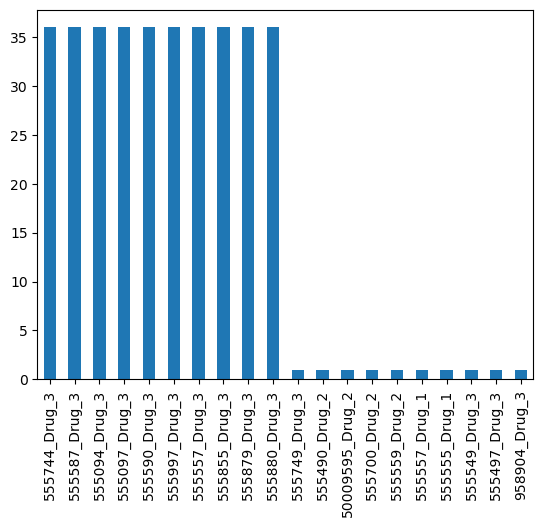

In [46]:
# Compare between top 10 and bottom 10 customers and drug based on record count
# Demand forecasting require historical data hence the top few demand can be forecasted
# While the bottom few cant be forecasted due to lack of historical data
dfTSAll['id'].value_counts().iloc[np.r_[0:10, -10:0]].plot.bar()
plt.show()

## Data preparation, exploration and modeling

In [47]:
# Take the top 3 customers that purchase a specific drug with the most consistent data based on year month date
idArr = []
for i in range(3):
    idArr.append(dfTSAll['id'].value_counts().iloc[0:3].reset_index().iloc[i][0])
    # dfComparison = dfComparison.append({'Data': idArr[i]}, ignore_index=True)
print(idArr)

['555744_Drug_3', '555587_Drug_3', '555094_Drug_3']


In [48]:
def decomposition(train, ele):
    decomposition = seasonal_decompose(np.log(train), model='additive', extrapolate_trend='freq')

    #Gather the trend, seasonality, and residuals
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot gathered statistics
    plt.figure(figsize=(10,6))
    plt.subplot(411)
    plt.title(f"Decomposition of data ({ele})", fontsize=18)
    plt.plot(train, label='Original', color='blue')
    plt.ylabel('Gross Sales', fontsize=12)
    plt.legend(loc='best')

    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.ylabel('Trend', fontsize=12)
    plt.legend(loc='best')

    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.ylabel('Seasonality', fontsize=12)
    plt.legend(loc='best')

    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.ylabel('Residuals', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend(loc='best')
    plt.tight_layout()
    # plt.savefig(f"Forecasting/decomposition_{ele}.png")
    plt.show()
    
    mpl.rcParams.update(mpl.rcParamsDefault)
    
    return residual

In [49]:
# To check for stationarity of data to determine presence of seasonality and trend
def stationarity_check(TS):
    # Calculate rolling statistics
    # Windows of 6 (Half a month)
    roll_mean = TS.rolling(window=6).mean()
    roll_std = TS.rolling(window=6).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return dfoutput

In [50]:
#Run ARIMA Model (Kindly note that this might take some time to run)
def arima(name, dfs, pdqArima):
    ans = []
    
    for df in dfs:
        for para1 in pdqArima:
                # try:
            df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)
            mod = SARIMAX(df,
                                            order = para1,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            output = mod.fit()
            ans.append([name, para1, output.aic])

            # print('Result for {}'.format(name) + ' ARIMA {} : AIC Calculated = {}'.format(para1, output.aic))
    
    
    result = pd.DataFrame(ans, columns = ['name','pdq','AIC'])
    display(result)

    #Return the best set of parameters based on AIC test
    best_para = result.loc[result.groupby("name")["AIC"].idxmin()]
    print(f"Best parameter by AIC = {best_para}")


    # plug the optimal parameter values into a new ARIMA model.
    for name, pdqPara, df in zip(best_para['name'], best_para['pdq'], dfs):

        df.index = pd.DatetimeIndex(df.index.values,
                                   freq=df.index.inferred_freq)
        ARIMA_MODEL = SARIMAX(df, 
                               order = pdqPara,
                               enforce_stationarity = False,
                               enforce_invertibility = False)

        # Fit the model and print results
        output = ARIMA_MODEL.fit()
        print('ARIMA Model Result for {}'.format(name))
        print(output.summary())

    for name, pdqPara, df in zip(best_para['name'], best_para['pdq'], dfs):

        df.index = pd.DatetimeIndex(df.index.values,
                                   freq=df.index.inferred_freq)
        ARIMA_MODEL = SARIMAX(df,
                              order = pdqPara,
                              enforce_stationarity = False,
                              enforce_invertibility=False)

        output = ARIMA_MODEL.fit()

        #get dynamic predictions starting 2021-01-01
        pred_dynamic = output.get_prediction(start='2021-01-01', end='2021-12-01', dynamic = True, full_results = True)
        pred_dynamic_conf = pred_dynamic.conf_int()
        zip_forecasted = pred_dynamic.predicted_mean
        zip_truth = df['2021-01-01':]['amt']

        #Plot the dynamic forecast with confidence intervals as above
        ax = df['2019':].plot(label='observed', figsize=(10, 8))
        pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

        ax.fill_between(pred_dynamic_conf.index,
                        pred_dynamic_conf.iloc[:, 0],
                        pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

        ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2021-01-01'), zip_forecasted.index[-1], alpha=.1, zorder=-1)

        plt.legend()
        plt.show()
        
    # Return forecasted values
    return zip_forecasted

In [51]:
#Function to run SARIMA Model (Kindly note that this might take some time to run)
def sarima(name, dfs, pdq, pdqs):
    ans=[]
    
    for df in dfs:
        for para1 in pdq:
            for para2 in pdqs:
                df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)
                mod = SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                
    result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])
    
    #Return the best set of parameters based on AIC test
    best_para = result.loc[result.groupby("name")["AIC"].idxmin()]
    print(f"Best parameter by AIC = {best_para}")
    
    # plug the optimal parameter values into a new SARIMAX model
    for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], dfs):

        df.index = pd.DatetimeIndex(df.index.values,
                                   freq=df.index.inferred_freq)
        ARIMA_MODEL = SARIMAX(df, 
                               order = pdq,
                               seasonal_order = pdqs,
                               enforce_stationarity = False,
                               enforce_invertibility = False)

        # Fit the model and print results
        output = ARIMA_MODEL.fit()
        print('SARIMA Model Result for {}'.format(name))
        print(output.summary())

    # Perform SARIMAX model fitting and prediction
    for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], dfs):

        df.index = pd.DatetimeIndex(df.index.values,
                                   freq=df.index.inferred_freq)
        ARIMA_MODEL = SARIMAX(df,
                                     order = pdq,
                                     seasonal_order = pdqs,
                                     enforce_stationarity = False,
                           enforce_invertibility=False)

        output = ARIMA_MODEL.fit()

        #get dynamic predictions starting 2021-01-01
        pred_dynamic = output.get_prediction(start='2021-01-01', end='2021-12-01', dynamic = True, full_results = True)
        pred_dynamic_conf = pred_dynamic.conf_int()
        zip_forecasted = pred_dynamic.predicted_mean
        print(zip_forecasted)
        zip_truth = df['2021-01-01':]['amt']

        #Plot the dynamic forecast with confidence intervals as above
        ax = df['2019':].plot(label='observed', figsize=(10, 8))
        pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

        ax.fill_between(pred_dynamic_conf.index,
                        pred_dynamic_conf.iloc[:, 0],
                        pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

        ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2021-01-01'), zip_forecasted.index[-1], alpha=.1, zorder=-1)

        plt.legend()
        plt.show()
        
    # Return forecasted values
    return zip_forecasted

In [52]:
dfTSAll[dfTSAll['id'] == idArr[1]][['fscl_yr_mo', 'amt']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 1968 to 2003
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   fscl_yr_mo  36 non-null     datetime64[ns]
 1   amt         36 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 864.0 bytes


Calculating index: 1 of item (555744_Drug_3)
Average test values = amt    2810.111283
dtype: float64


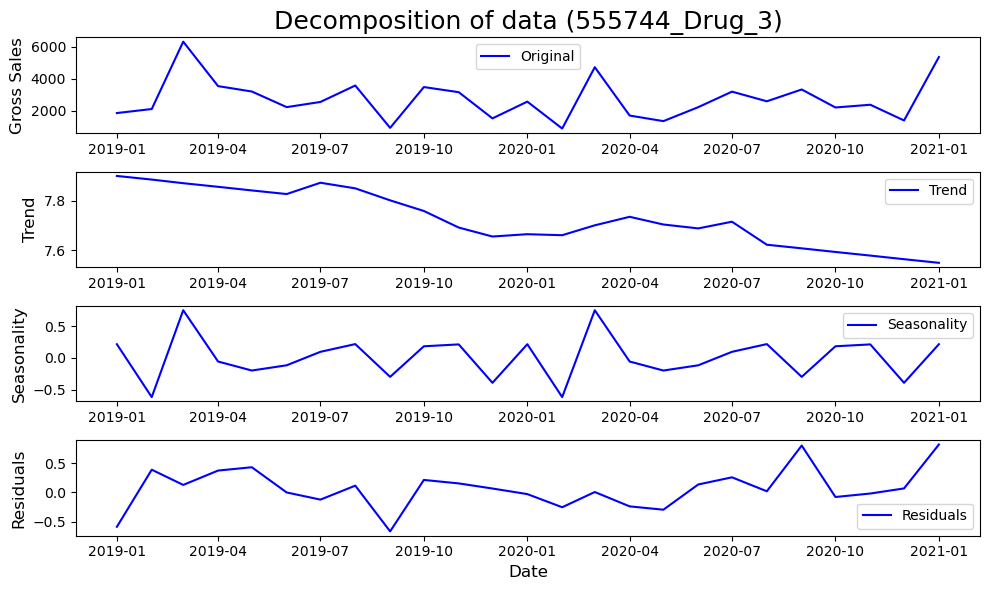

Results of Dickey-Fuller Test: 

Test Statistic                 -4.882905
p-value                         0.000038
#Lags Used                      0.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64
Test Statistic                 -4.882905
p-value                         0.000038
#Lags Used                      0.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64

The p-value is smaller than significance level (0.05). We reject the null hypothesis which means the residuals and data are stationary.


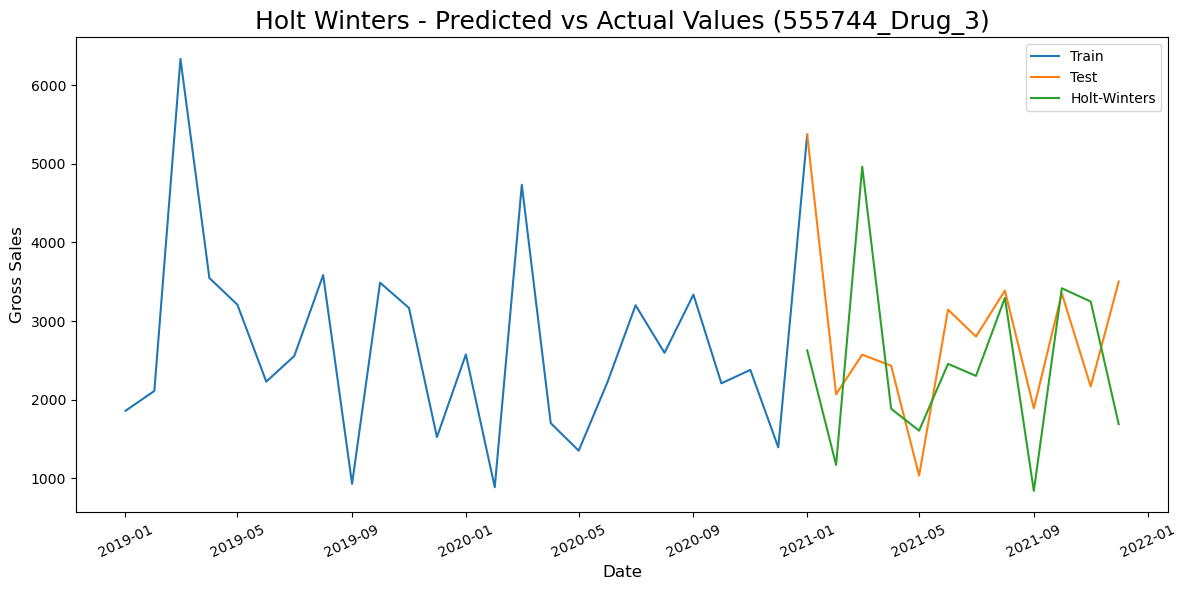

Holt-Winters Mean Absolute Error(MAE) = 1036.824308404274
Holt-Winters Root Mean Square Error(RMSE) = 1321.8461483992817
[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


name        pdq         AIC
0  sales_prediction  (0, 0, 0)  455.517811
1  sales_prediction  (0, 0, 1)  429.161738
2  sales_prediction  (0, 1, 0)  417.166037
3  sales_prediction  (0, 1, 1)  379.021224
4  sales_prediction  (1, 0, 0)  434.692784
5  sales_prediction  (1, 0, 1)  405.289341
6  sales_prediction  (1, 1, 0)  411.378763
7  sales_prediction  (1, 1, 1)  378.709591

Best parameter by AIC =                name        pdq         AIC
7  sales_prediction  (1, 1, 1)  378.709591
ARIMA Model Result for sales_prediction
                               SARIMAX Results                                
Dep. Variable:                    amt   No. Observations:                   25
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -186.355
Date:                Mon, 11 Jul 2022   AIC                            378.710
Time:                        18:46:04   BIC                            381.983
Sample:                    01-01-2019   HQIC                           379.481
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2360      0.223     -1.057      0.291      

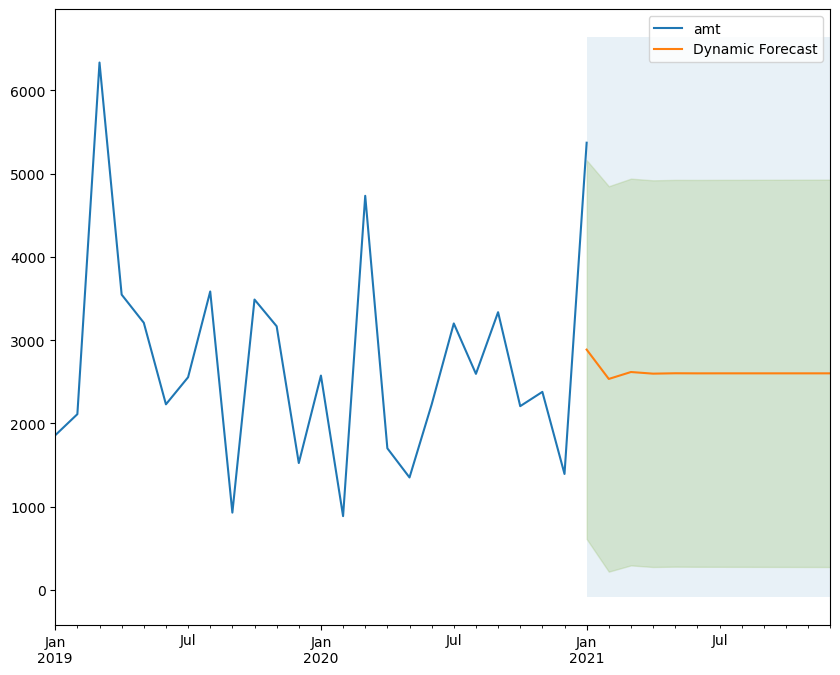

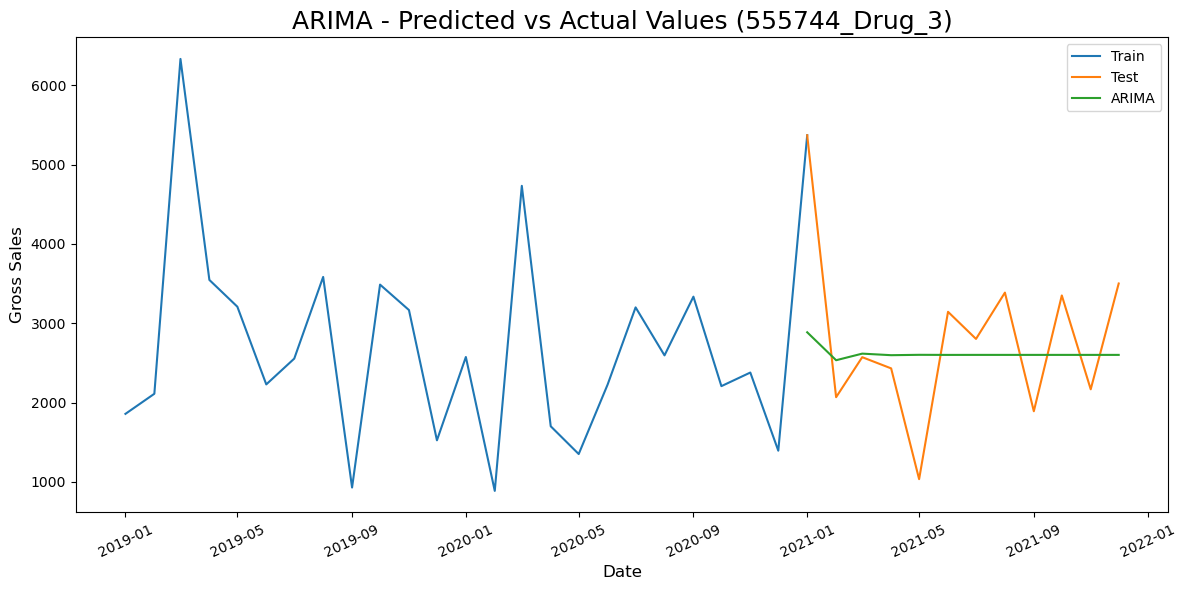

ARIMA Mean Absolute Error(MAE) = 754.494193641191
ARIMA Root Mean Square Error(RMSE) = 995.6085603592629


C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All p

Best parameter by AIC =                 name        pdq           pdqs       AIC
14  sales_prediction  (0, 0, 1)  (1, 1, 0, 12) -6.808966
SARIMA Model Result for sales_prediction
                                      SARIMAX Results                                      
Dep. Variable:                                 amt   No. Observations:                   25
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 12)   Log Likelihood                   6.404
Date:                             Mon, 11 Jul 2022   AIC                             -6.809
Time:                                     18:46:09   BIC                            -12.809
Sample:                                 01-01-2019   HQIC                              -inf
                                      - 01-01-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------

C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\tools\eval_measures.py:431: RuntimeWarning: divide by zero encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


2021-01-01     5370.653525
2021-02-01    -3888.587064
2021-03-01    -1507.760927
2021-04-01    -5495.671035
2021-05-01    -5894.101399
2021-06-01     2219.154191
2021-07-01     5719.763080
2021-08-01    -1262.726093
2021-09-01    12721.440491
2021-10-01    -2785.222459
2021-11-01     -693.961816
2021-12-01      882.996027
Freq: MS, Name: predicted_mean, dtype: float64


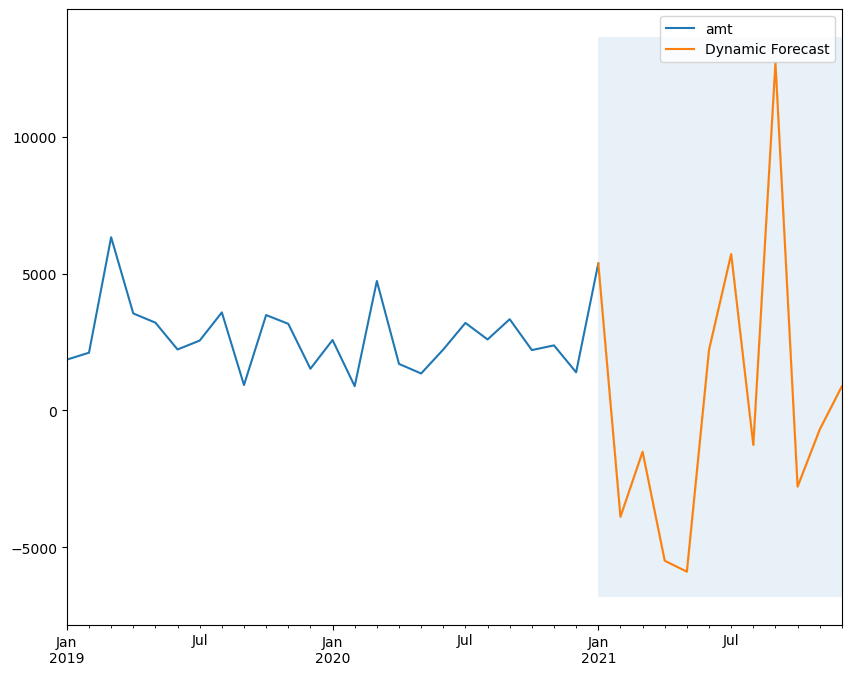

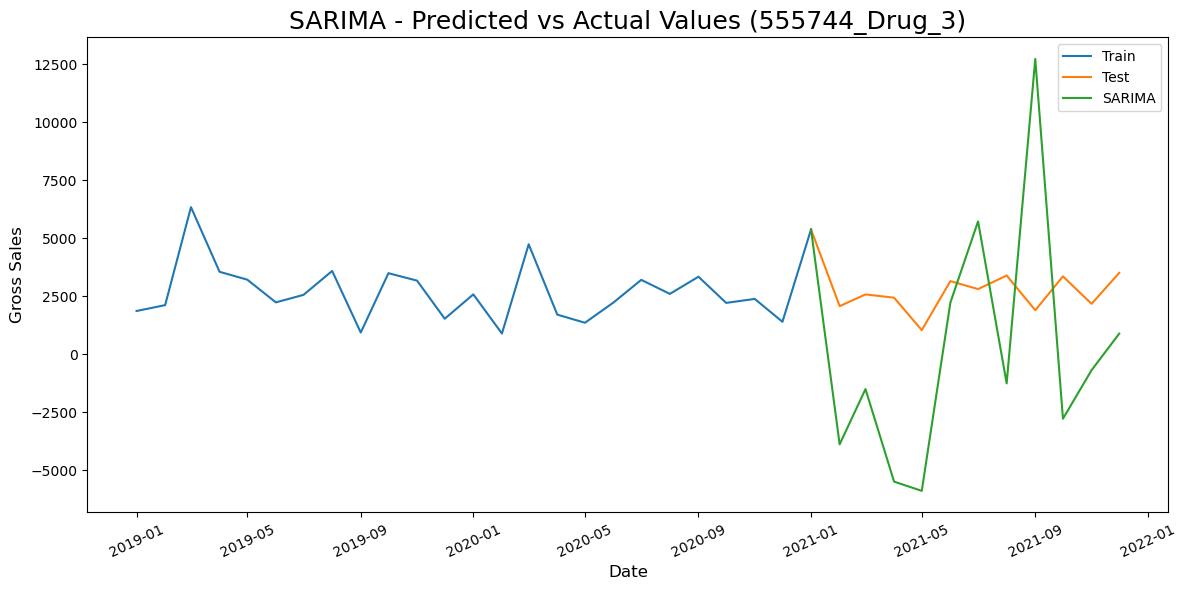

C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:n_changepoints greater than number of observations. Using 19.


SARIMA Mean Absolute Error(MAE) = 4652.603093356322
SARIMA Root Mean Square Error(RMSE) = 5507.242304269875


C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


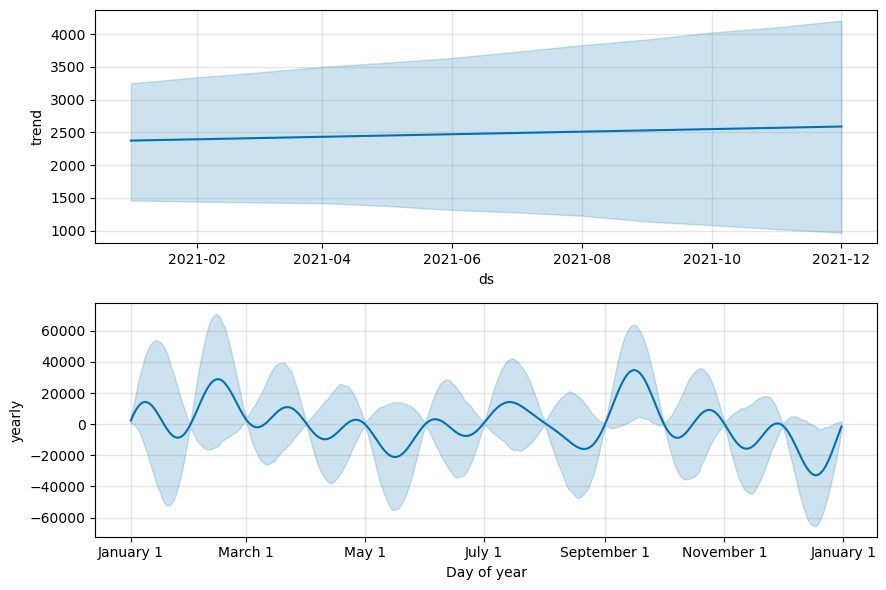

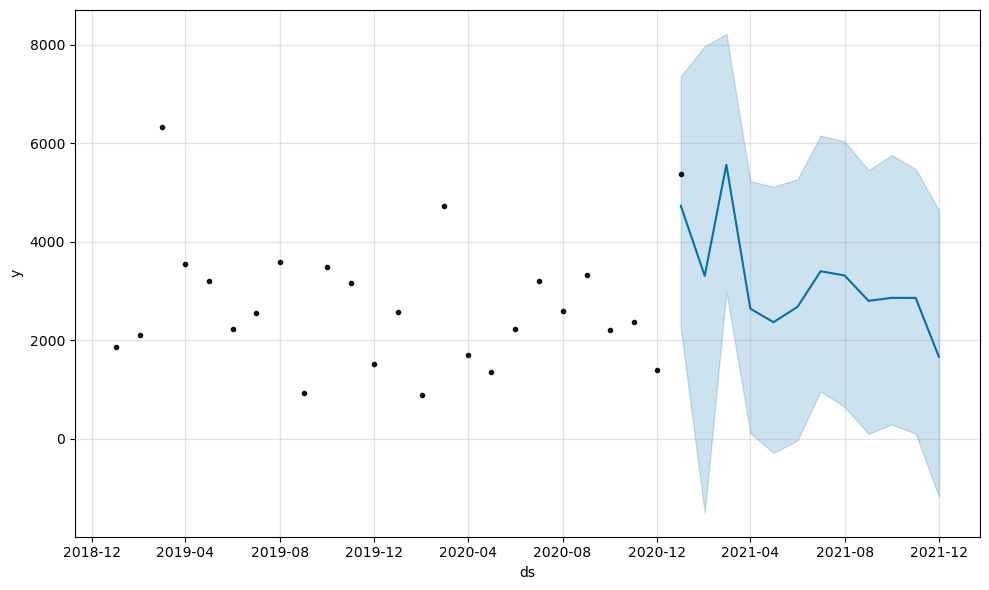

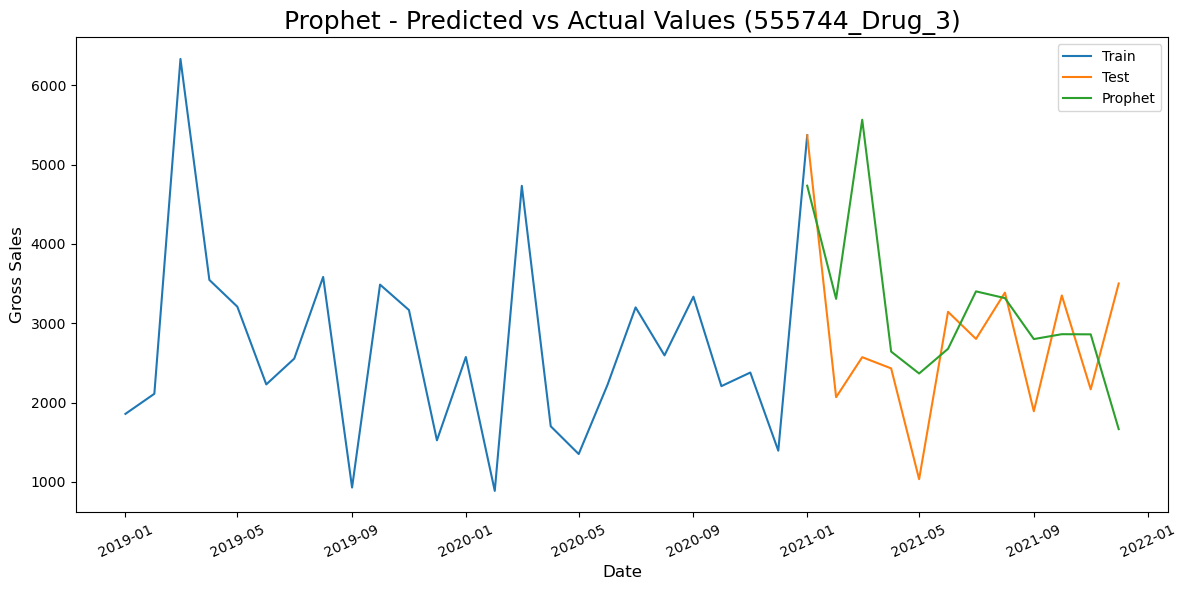

Calculating index: 2 of item (555587_Drug_3)
Average test values = amt    1993.830323
dtype: float64


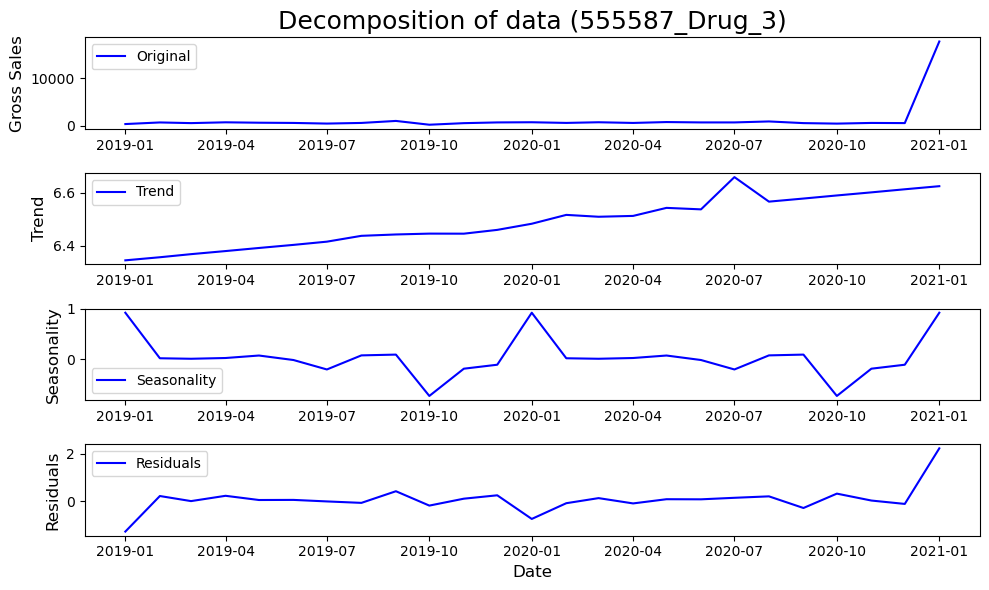

Results of Dickey-Fuller Test: 

Test Statistic                 -4.287651
p-value                         0.000467
#Lags Used                      0.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64
Test Statistic                 -4.287651
p-value                         0.000467
#Lags Used                      0.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64

The p-value is smaller than significance level (0.05). We reject the null hypothesis which means the residuals and data are stationary.


C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


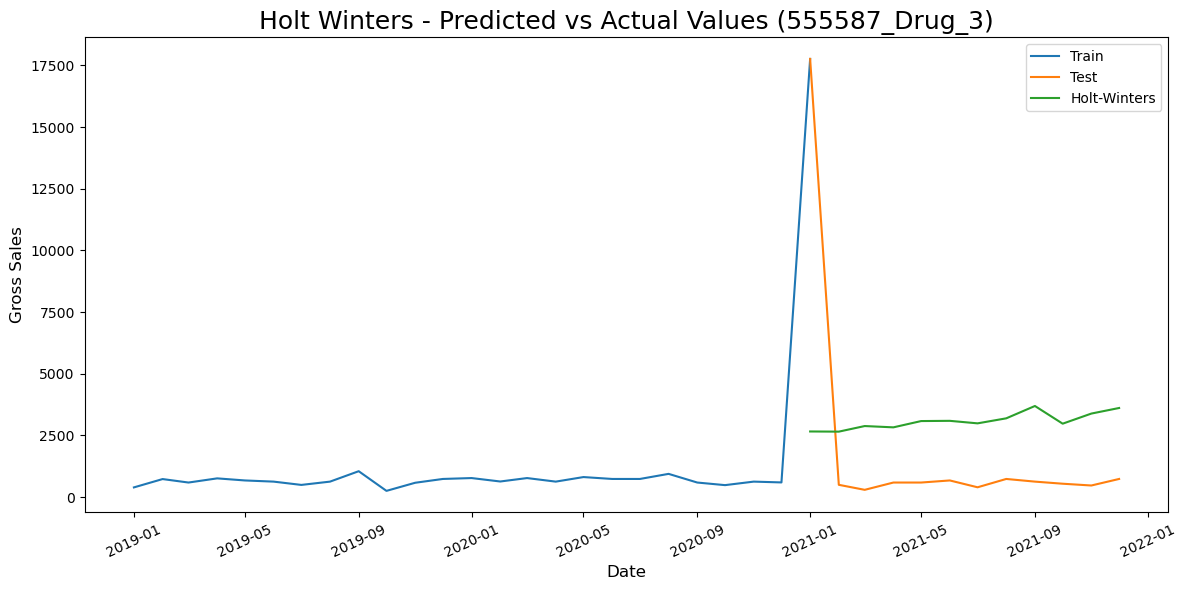

Holt-Winters Mean Absolute Error(MAE) = 3610.22711561834
Holt-Winters Root Mean Square Error(RMSE) = 5010.001838041521
[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


name        pdq         AIC
0  sales_prediction  (0, 0, 0)  464.330948
1  sales_prediction  (0, 0, 1)  459.116658
2  sales_prediction  (0, 1, 0)  443.786413
3  sales_prediction  (0, 1, 1)  427.540663
4  sales_prediction  (1, 0, 0)  463.300466
5  sales_prediction  (1, 0, 1)  445.520236
6  sales_prediction  (1, 1, 0)  445.698138
7  sales_prediction  (1, 1, 1)  429.501228

Best parameter by AIC =                name        pdq         AIC
3  sales_prediction  (0, 1, 1)  427.540663
ARIMA Model Result for sales_prediction
                               SARIMAX Results                                
Dep. Variable:                    amt   No. Observations:                   25
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -211.770
Date:                Mon, 11 Jul 2022   AIC                            427.541
Time:                        18:46:24   BIC                            429.723
Sample:                    01-01-2019   HQIC                           428.055
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7701     12.265     -0.063      0.950     -

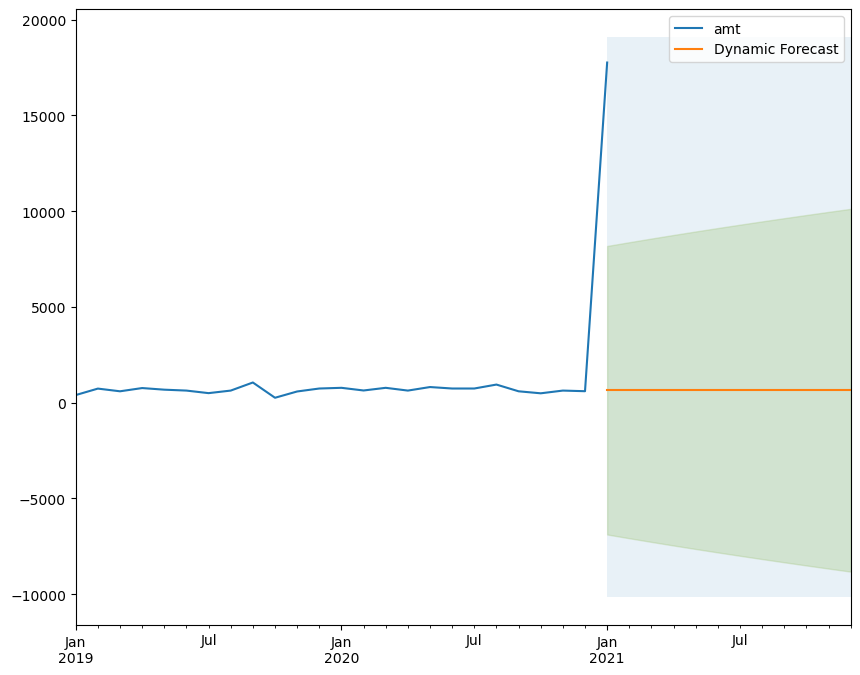

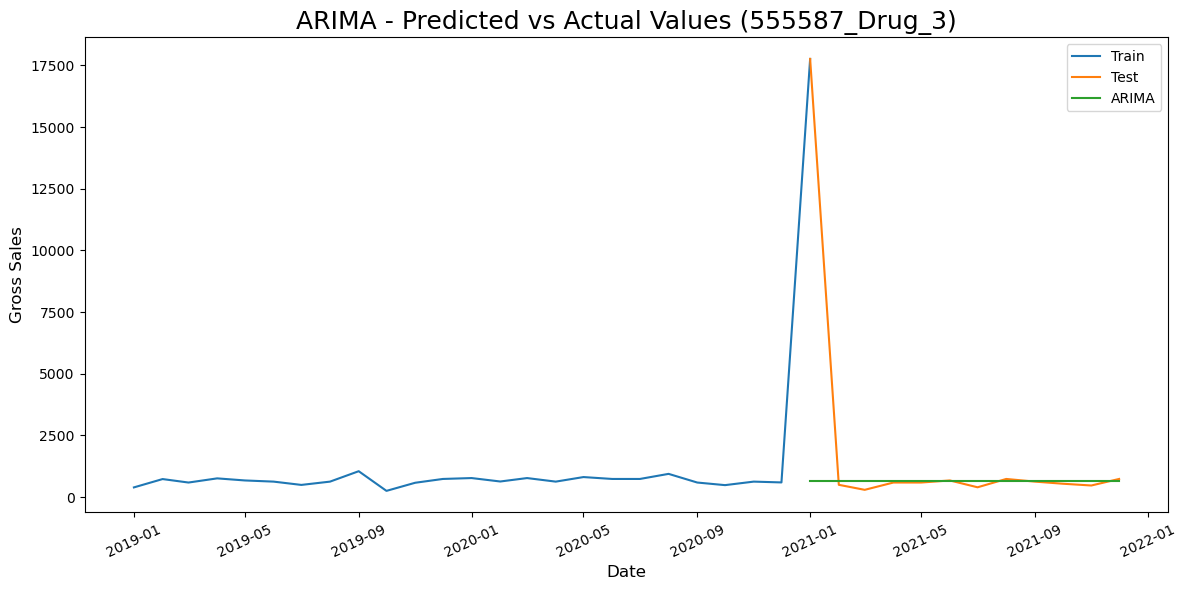

ARIMA Mean Absolute Error(MAE) = 1539.714199087706
ARIMA Root Mean Square Error(RMSE) = 4942.472318482218


C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All p

Best parameter by AIC =                name        pdq           pdqs  AIC
3  sales_prediction  (0, 0, 0)  (0, 1, 1, 12)  4.0
SARIMA Model Result for sales_prediction
                                 SARIMAX Results                                  
Dep. Variable:                        amt   No. Observations:                   25
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                   0.000
Date:                    Mon, 11 Jul 2022   AIC                              4.000
Time:                            18:46:28   BIC                               -inf
Sample:                        01-01-2019   HQIC                               nan
                             - 01-01-2021                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12   

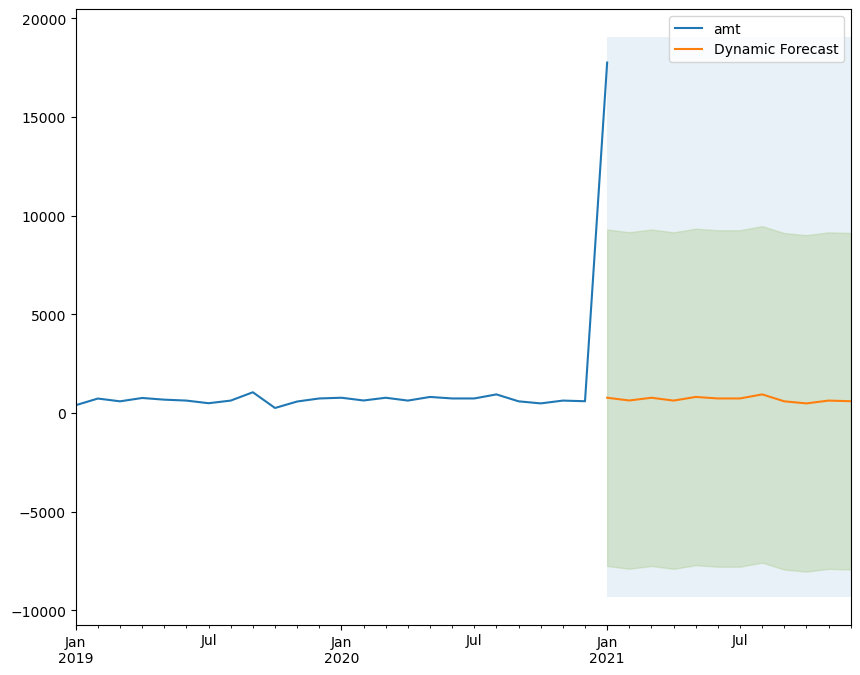

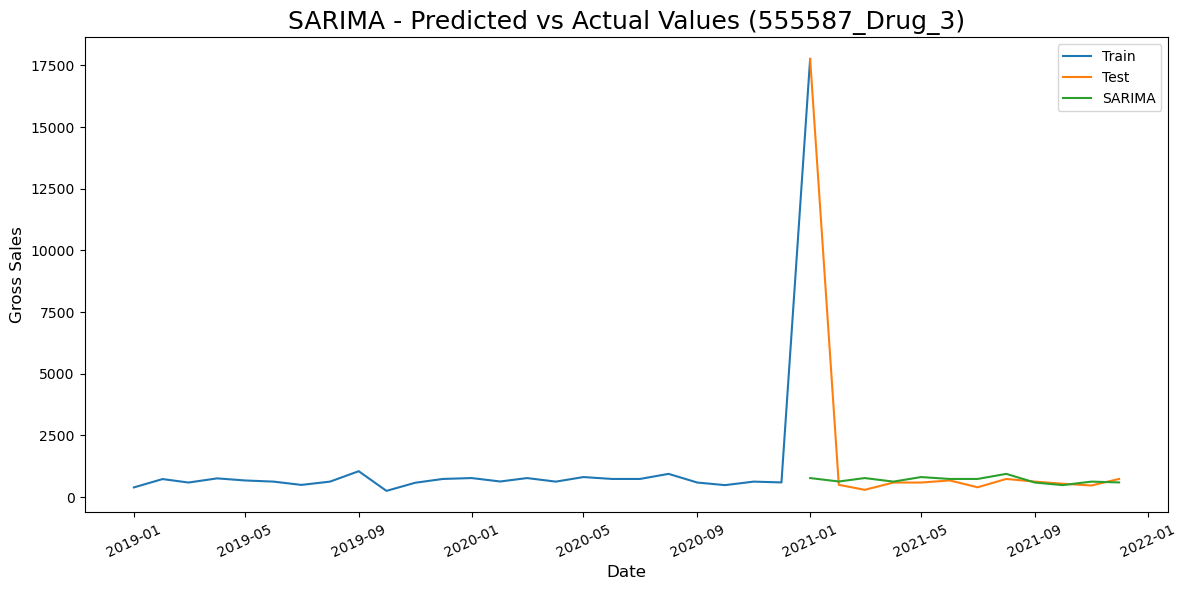

C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:n_changepoints greater than number of observations. Using 19.


SARIMA Mean Absolute Error(MAE) = 1571.1939658625
SARIMA Root Mean Square Error(RMSE) = 4908.077134436262


C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


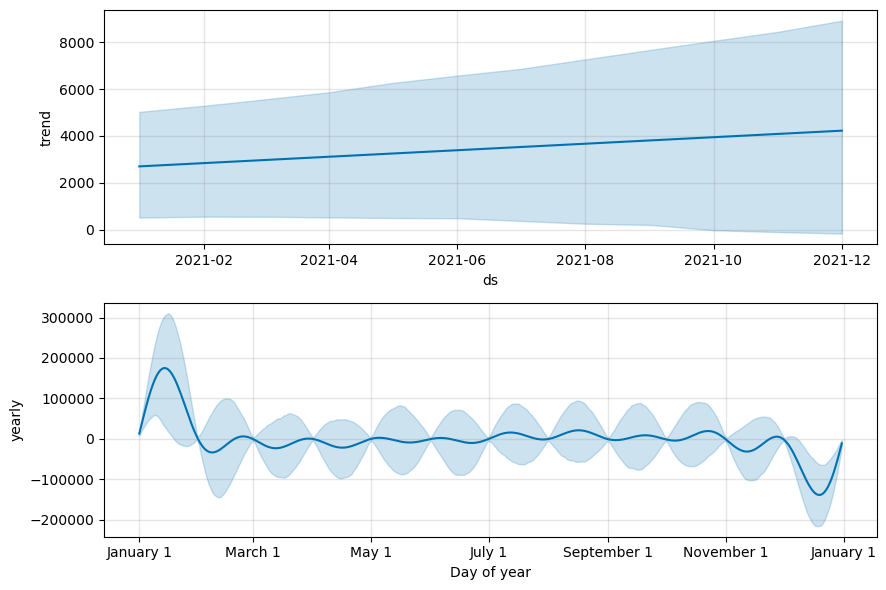

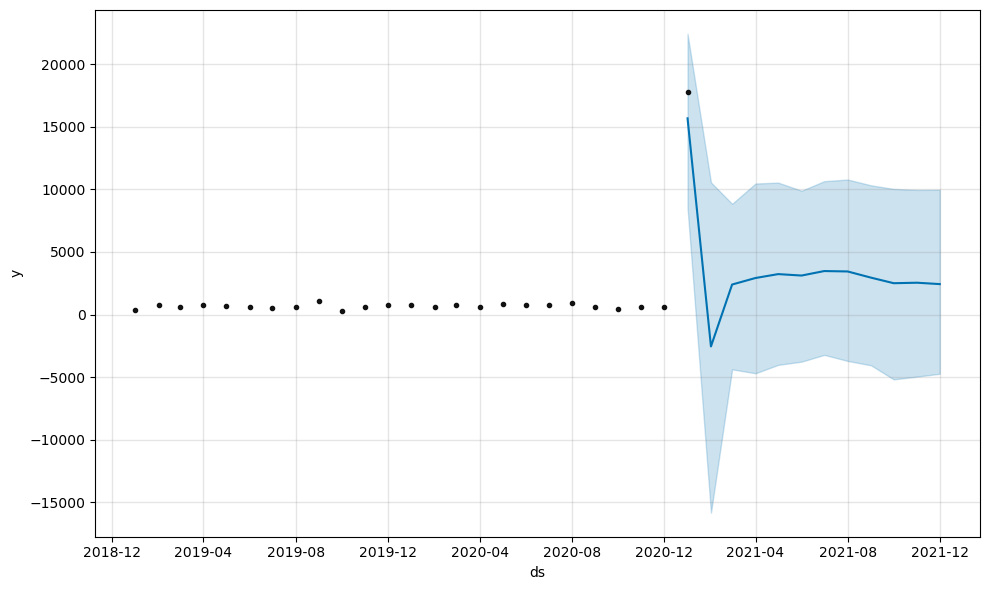

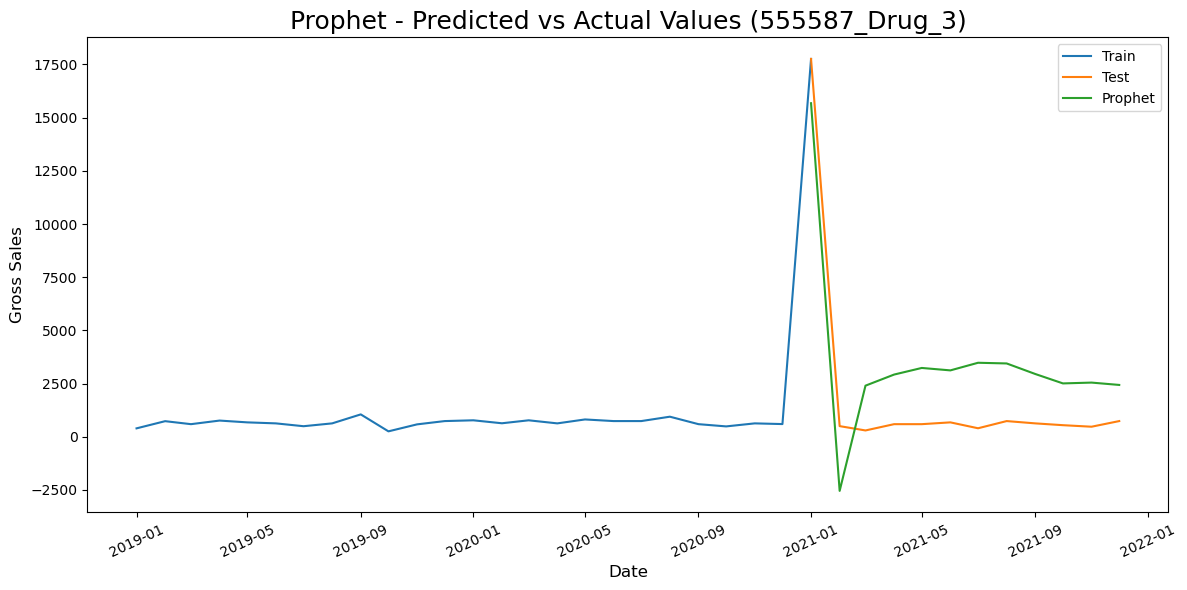

Calculating index: 3 of item (555094_Drug_3)
Average test values = amt    2556.093228
dtype: float64


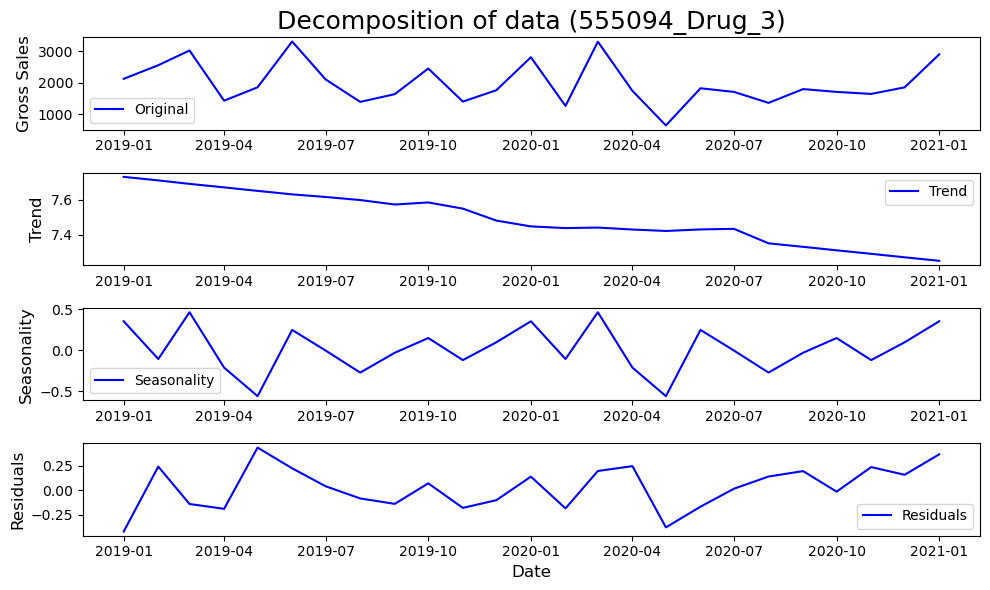

Results of Dickey-Fuller Test: 

Test Statistic                  0.583067
p-value                         0.987191
#Lags Used                      8.000000
Number of Observations Used    16.000000
Critical Value (1%)            -3.924019
Critical Value (5%)            -3.068498
Critical Value (10%)           -2.673893
dtype: float64
Test Statistic                  0.583067
p-value                         0.987191
#Lags Used                      8.000000
Number of Observations Used    16.000000
Critical Value (1%)            -3.924019
Critical Value (5%)            -3.068498
Critical Value (10%)           -2.673893
dtype: float64

The p-value is larger than significance level (0.05). We accept the null hypothesis which means the residuals and data are not stationary.


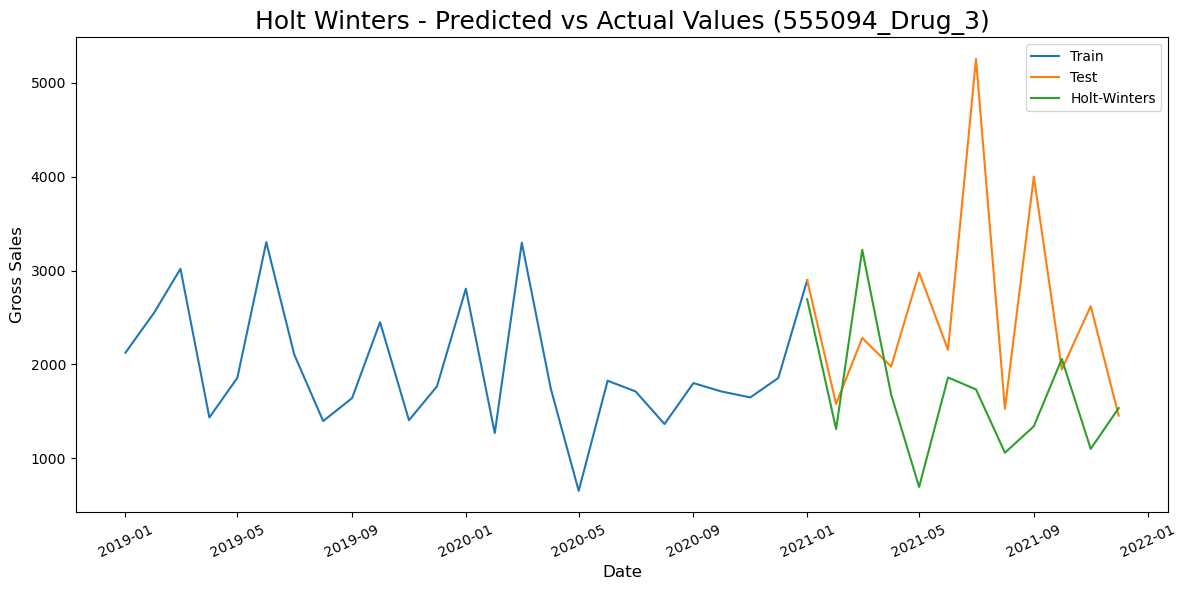

Holt-Winters Mean Absolute Error(MAE) = 1053.1978104264228
Holt-Winters Root Mean Square Error(RMSE) = 1537.3265469353873
[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


name        pdq         AIC
0  sales_prediction  (0, 0, 0)  437.089171
1  sales_prediction  (0, 0, 1)  401.213045
2  sales_prediction  (0, 1, 0)  384.856511
3  sales_prediction  (0, 1, 1)  356.450800
4  sales_prediction  (1, 0, 0)  401.709570
5  sales_prediction  (1, 0, 1)  373.266323
6  sales_prediction  (1, 1, 0)  381.943339
7  sales_prediction  (1, 1, 1)  357.743262

Best parameter by AIC =                name        pdq       AIC
3  sales_prediction  (0, 1, 1)  356.4508
ARIMA Model Result for sales_prediction
                               SARIMAX Results                                
Dep. Variable:                    amt   No. Observations:                   25
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -176.225
Date:                Mon, 11 Jul 2022   AIC                            356.451
Time:                        18:46:43   BIC                            358.633
Sample:                    01-01-2019   HQIC                           356.965
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0483      0.362     -2.898      0.004      -1.7

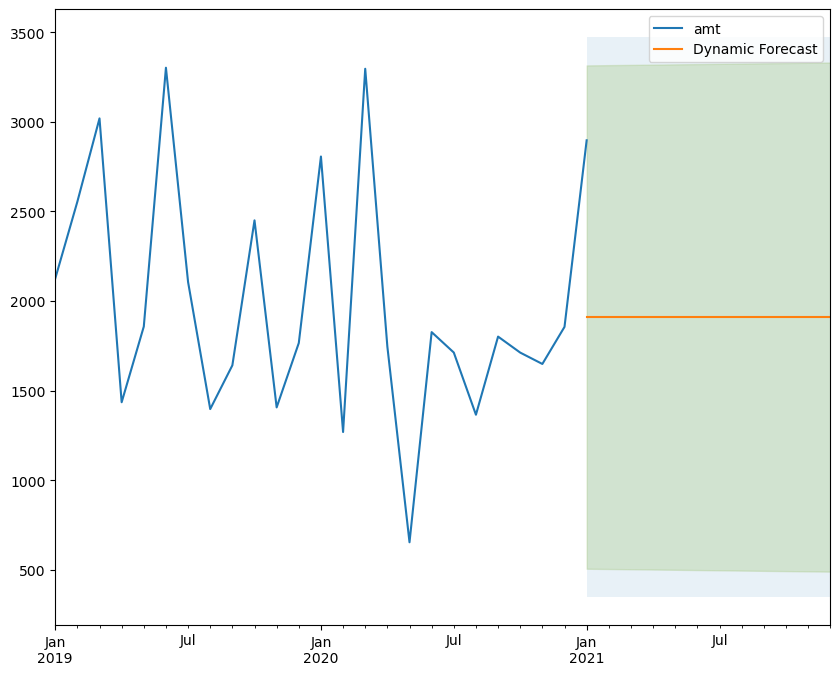

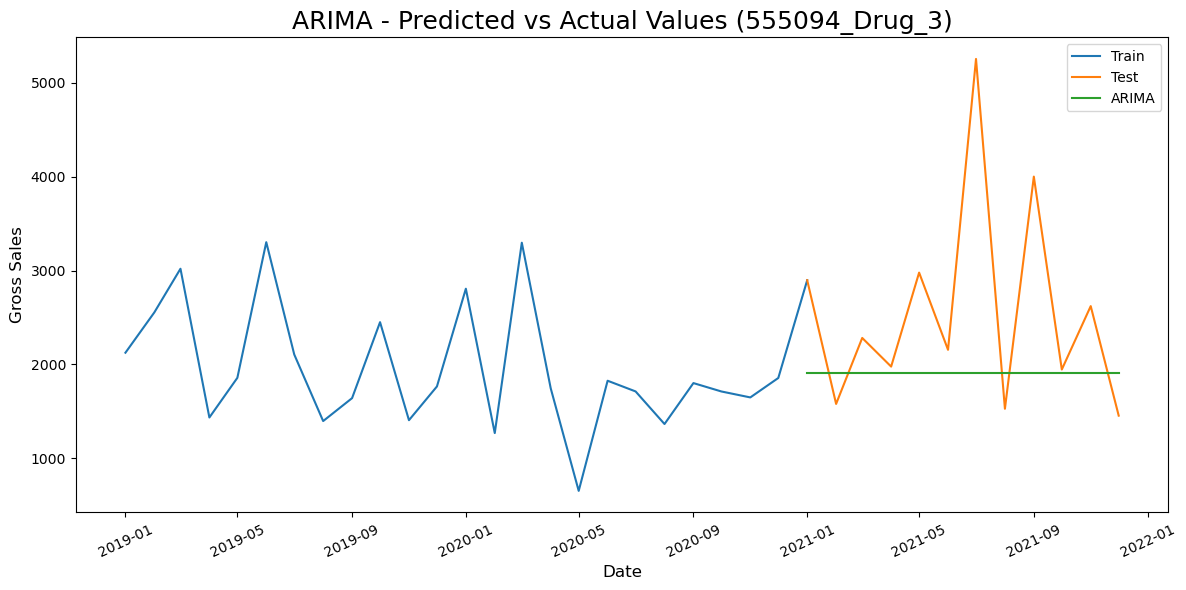

ARIMA Mean Absolute Error(MAE) = 840.1448761017174
ARIMA Root Mean Square Error(RMSE) = 1252.104930850823


C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All p

Best parameter by AIC =                name        pdq           pdqs      AIC
6  sales_prediction  (0, 0, 0)  (1, 1, 0, 12) -7.18008


C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\tools\eval_measures.py:431: RuntimeWarning: divide by zero encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


SARIMA Model Result for sales_prediction
                                SARIMAX Results                                 
Dep. Variable:                      amt   No. Observations:                   25
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                   5.590
Date:                  Mon, 11 Jul 2022   AIC                             -7.180
Time:                          18:46:47   BIC                            -11.180
Sample:                      01-01-2019   HQIC                              -inf
                           - 01-01-2021                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.1326   1.65e-06   8.06e+04      0.000       0.133       0.133
sigma2      1.034e-06    3.2e-07      3.229      0.001    4.06e-07    1.66

C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2021-01-01    2896.768756
2021-02-01    1099.114846
2021-03-01    3332.662034
2021-04-01    1787.033584
2021-05-01     494.840134
2021-06-01    1631.166694
2021-07-01    1660.766366
2021-08-01    1361.788917
2021-09-01    1823.046357
2021-10-01    1614.670993
2021-11-01    1681.336666
2021-12-01    1868.009800
Freq: MS, Name: predicted_mean, dtype: float64


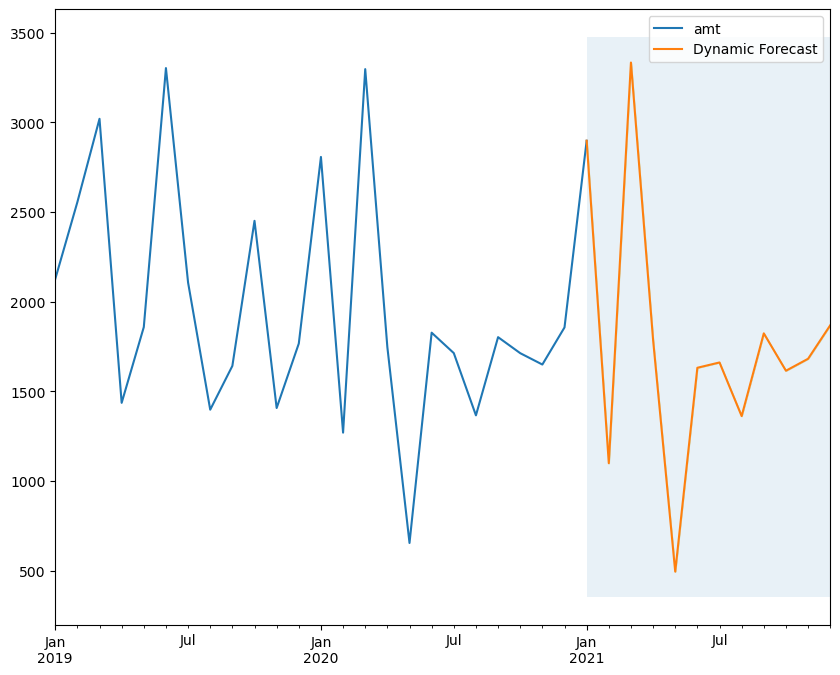

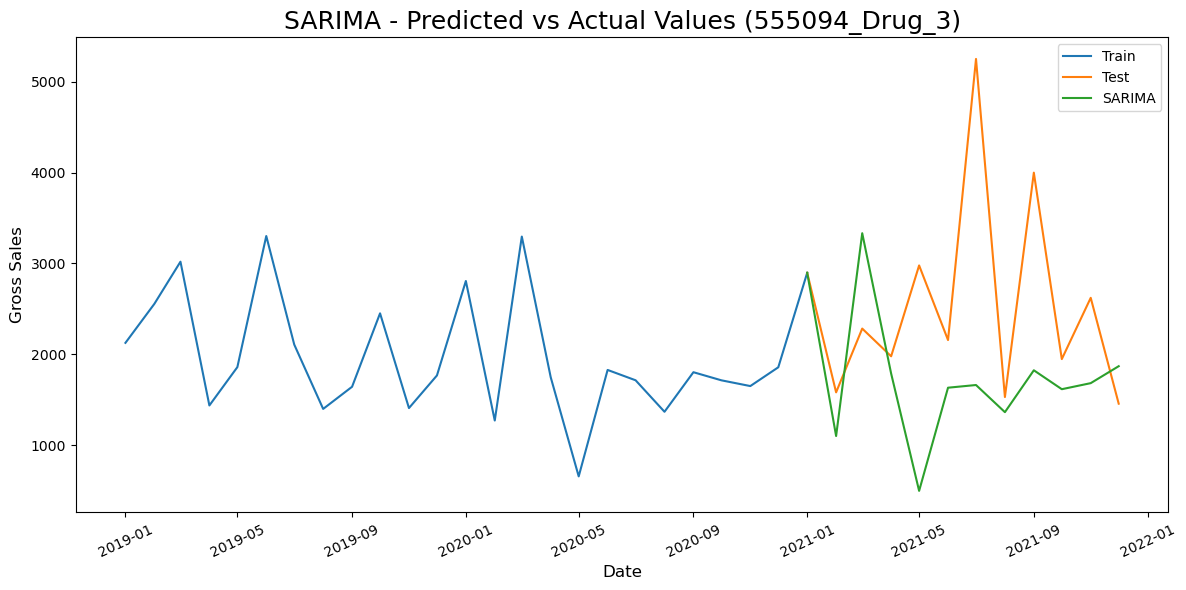

C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:n_changepoints greater than number of observations. Using 19.


SARIMA Mean Absolute Error(MAE) = 1029.0288024849674
SARIMA Root Mean Square Error(RMSE) = 1489.9653749498566


C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\dustb\anaconda3\envs\cap_py38\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


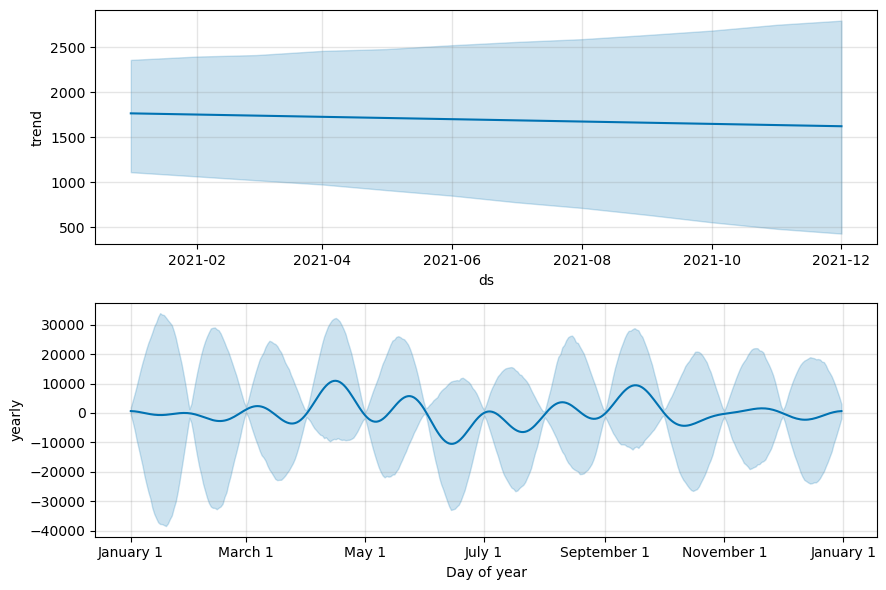

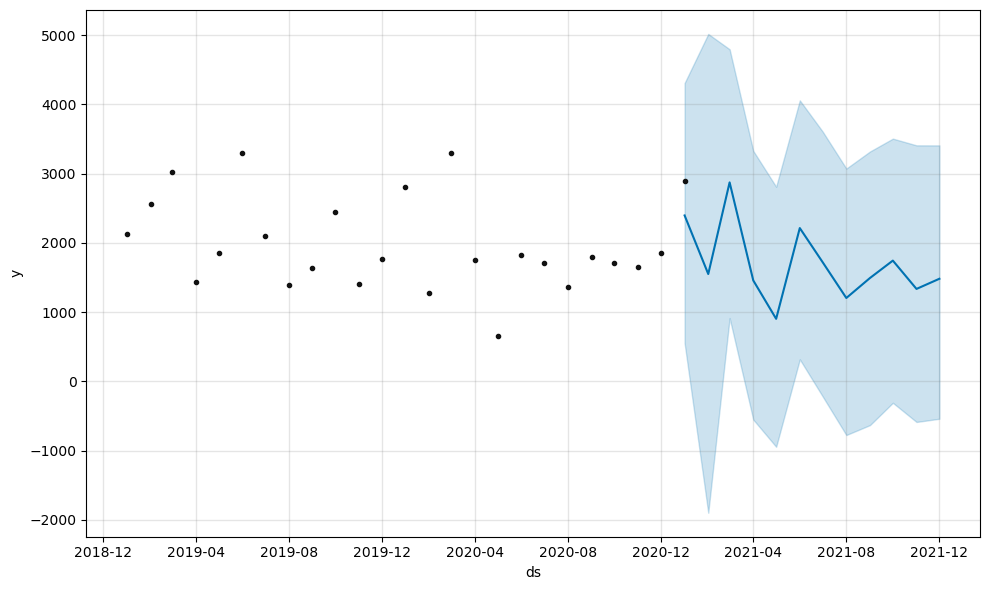

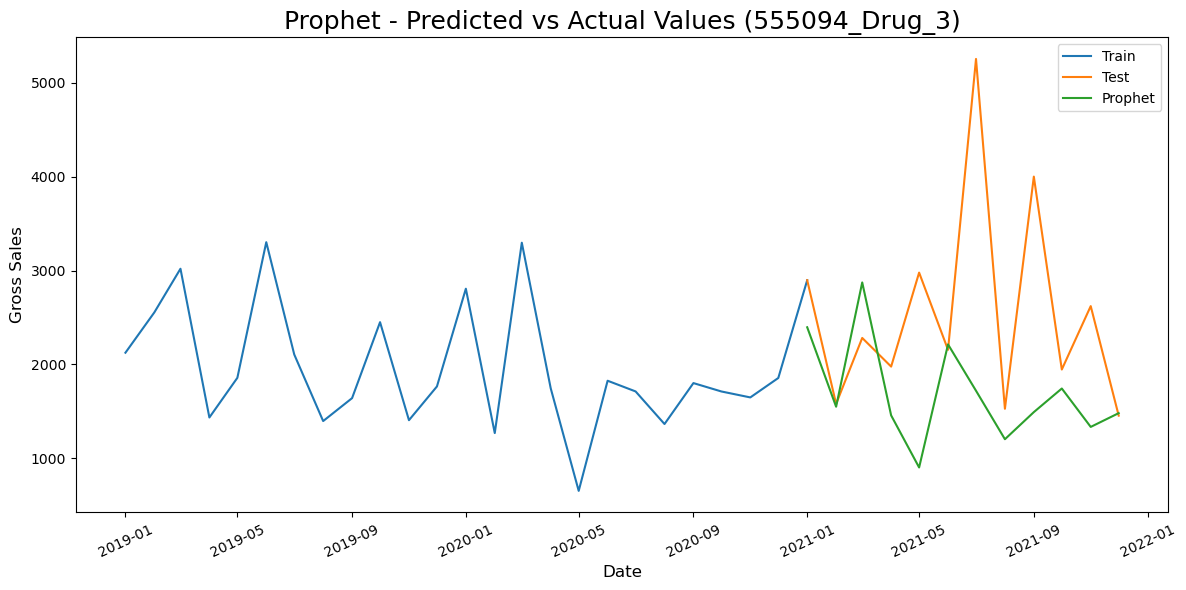

Seasonality MeanAbsoluteError RootMeanSquaredError
Data          Model                                                          
555744_Drug_3 Holt-Winters        True       1036.824308          1321.846148
              ARIMA               True        754.494194            995.60856
              SARIMA              True       4652.603093          5507.242304
              Prophet             True        956.423155           1232.40357
555587_Drug_3 Holt-Winters        True       3610.227116          5010.001838
              ARIMA               True       1539.714199          4942.472318
              SARIMA              True       1571.193966          4908.077134
              Prophet             True       2374.491191          2409.509846
555094_Drug_3 Holt-Winters       False        1053.19781          1537.326547
              ARIMA              False        840.144876          1252.104931
              SARIMA             False       1029.028802          1489.965375
              Prophet            False        970.865901          1464.462426

In [216]:
mpl.rcParams.update(mpl.rcParamsDefault)

dfComparison = pd.DataFrame(columns=['Data', 'Stationarity', 'Model', 'MeanAbsoluteError', 'RootMeanSquaredError'])

for idx, ele in enumerate(idArr):
    print(f"Calculating index: {idx+1} of item ({ele})")
    dfTSData = dfTSAll[dfTSAll['id'] == idArr[idx]][['fscl_yr_mo', 'amt']].copy()
    dfTSData = dfTSData.set_index('fscl_yr_mo').asfreq('MS')

    # Split data into train and test set
    tsTrain_ind = int(len(dfTSData)*0.67)
    tsTrain = dfTSData[:tsTrain_ind+1]
    tsTest = dfTSData[tsTrain_ind:]
    print(f"Average test values = {tsTest.mean()}")
    dfTSEval = tsTest.copy()
    
    
    # # Plot Train and Test data
    # sns.lineplot(data=tsTrain, palette=['blue'], legend=None)
    # sns.lineplot(data=tsTest, palette=['orange'], legend=None)
    # plt.xticks(rotation=45)
    # plt.legend(labels=["Train","Test"])
    # plt.title(f"Train-Test for {ele}")
    # plt.tight_layout()
    # plt.show()
    
    residual = decomposition(tsTrain, ele)
    
    ts_log_decompose = residual
    ts_log_decompose.dropna(inplace=True)
    
    adfResult = stationarity_check(ts_log_decompose)
    print(adfResult)
    
    if ((adfResult[1].round(2)) > 0.05):
        stationarity = False
        print("\nThe p-value is larger than significance level (0.05). We accept the null hypothesis which means the residuals and data are not stationary.")
    else:
        stationarity = True
        print("\nThe p-value is smaller than significance level (0.05). We reject the null hypothesis which means the residuals and data are stationary.")
    
#     # Plot ACF and PACF to check for seasonality and autocorrelation
#     plot_acf(tsTrain, lags=23)
#     plt.xlabel('lag')
#     plt.ylabel('Autocorrelation')
#     # plt.xlim(0,24)
#     plt.show()

#     plot_pacf(tsTrain, method='ywm', lags=11)
#     plt.xlabel('lag')
#     plt.ylabel('Partial Autocorrelation')
#     # plt.xlim(0, 24)
#     plt.ylim(-1, 1)
#     plt.show()
    
    # Predict with Holt-Winters Time Series Model
    hwModel = ExponentialSmoothing(tsTrain, seasonal='add', trend='add', seasonal_periods=12, freq='MS').fit()
    hwResult = hwModel.predict(start='2021-01-01', end='2021-12-01')
    
    dfTSEval['holtwintersAmt'] = hwResult.values
    hwMAE = mean_absolute_error(dfTSEval['amt'], hwResult.values)
    hwRMSE = mean_squared_error(dfTSEval['amt'], hwResult.values, squared=False)
    
    
    dfHWEval = pd.DataFrame({'Data':ele, 'Stationarity':stationarity, 'Model':'Holt-Winters', 'MeanAbsoluteError': hwMAE, 'RootMeanSquaredError': hwRMSE}, index=[0])
    dfComparison = pd.concat([dfComparison, dfHWEval], join='outer')

    plt.figure(figsize=(12,6))
    plt.plot(tsTrain, label='Train')
    plt.plot(tsTest, label='Test')
    plt.plot(hwResult, label='Holt-Winters')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Gross Sales', fontsize=12)
    plt.title(f"Holt Winters - Predicted vs Actual Values ({ele})", fontsize=18)
    plt.legend(loc='best')
    plt.xticks(rotation=25)
    plt.tight_layout()
    # plt.savefig(f"Forecasting/holtwinters_{ele}.png")
    plt.show()
    
    print(f"Holt-Winters Mean Absolute Error(MAE) = {hwMAE}")
    print(f"Holt-Winters Root Mean Square Error(RMSE) = {hwRMSE}")
    
    # Prepare Arima and Sarima models parameters for AIC test
    # Define the p, d and q parameters to take any value between 0 and 1
    p = d = q = range(0,2)

    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p,d,q))
    print(pdq)

    # Generate all different combinations of p, d and q triplets for Arima model
    pdqArima = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]
    pdqArima
    
    # Data for Arima and Sarima models
    # ans = []
    dfs = [tsTrain]
    name = "sales_prediction"
    
    arimaResult = arima(name, dfs, pdqArima)
    
    dfTSEval['arimaAmt'] = arimaResult.values
    arimaMAE = mean_absolute_error(dfTSEval['amt'], arimaResult.values)
    arimaRMSE = mean_squared_error(dfTSEval['amt'], arimaResult.values, squared=False)
    
    dfArimaEval = pd.DataFrame({'Data':ele, 'Stationarity':stationarity, 'Model':'ARIMA', 'MeanAbsoluteError': arimaMAE, 'RootMeanSquaredError': arimaRMSE}, index=[0])
    dfComparison = pd.concat([dfComparison, dfArimaEval], join='outer')

    # Predict the next year (Out-of-sample prediction)
    plt.figure(figsize=(12,6))
    plt.plot(tsTrain, label='Train')
    plt.plot(tsTest, label='Test')
    plt.plot(arimaResult, label='ARIMA')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Gross Sales', fontsize=12)
    plt.title(f"ARIMA - Predicted vs Actual Values ({ele})", fontsize=18)
    plt.legend(loc='best')
    plt.xticks(rotation=25)
    plt.tight_layout()
    # plt.savefig(f"Forecasting/arima_{ele}.png")
    plt.show()
    
    print(f"ARIMA Mean Absolute Error(MAE) = {arimaMAE}")
    print(f"ARIMA Root Mean Square Error(RMSE) = {arimaRMSE}")
    
    # Generate all different combinations of seasonal p, d and q triplets for Sarima model
    # Seasonality of dataset is monthly - S = 12 (months per year)
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    pdqs
    
    sarimaResult = sarima(name, dfs, pdq, pdqs)
    
    dfTSEval['sarimaAmt'] = sarimaResult.values
    sarimaMAE = mean_absolute_error(dfTSEval['amt'], sarimaResult.values)
    sarimaRMSE = mean_squared_error(dfTSEval['amt'], sarimaResult.values, squared=False)
    
    dfSarimaEval = pd.DataFrame({'Data':ele, 'Stationarity':stationarity, 'Model':'SARIMA', 'MeanAbsoluteError': sarimaMAE, 'RootMeanSquaredError': sarimaRMSE}, index=[0])
    dfComparison = pd.concat([dfComparison, dfSarimaEval], join='outer')
    
    # Predict the next year (Out-of-sample prediction)
    plt.figure(figsize=(12,6))
    plt.plot(tsTrain, label='Train')
    plt.plot(tsTest, label='Test')
    plt.plot(sarimaResult, label='SARIMA')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Gross Sales', fontsize=12)
    plt.title(f"SARIMA - Predicted vs Actual Values ({ele})", fontsize=18)
    plt.legend(loc='best')
    plt.xticks(rotation=25)
    plt.tight_layout()
    # plt.savefig(f"Forecasting/sarima_{ele}.png")
    plt.show()
    
    print(f"SARIMA Mean Absolute Error(MAE) = {sarimaMAE}")
    print(f"SARIMA Root Mean Square Error(RMSE) = {sarimaRMSE}")
    
    # Prepare Time Series dataframe for Prophet
    prophetTrain = tsTrain.reset_index().set_axis(['ds', 'y'], axis=1)
    prophetTest = tsTest.reset_index().set_axis(['ds', 'y'], axis=1)
    
    # Fitting and training of time series data
    # MCMC samples to see the uncertainty in the forecast
    prophetModel = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, mcmc_samples=300).fit(prophetTrain)

    # Out-of-sample prediction with 12 more months appended into the train dataset
    # future = prophetModel.make_future_dataframe(periods=12, freq='MS')
    fcst = prophetModel.predict(prophetTest)

    # Plot the trend and seasonality
    fig = prophetModel.plot_components(fcst)
    plt.show()
    # Plot the values and out of sample prediction
    fig = prophetModel.plot(fcst)
    plt.show()

    # Plot the monthly prediction of the next year (Out-of-sample prediction)
    plt.figure(figsize=(12,6))
    plt.plot(tsTrain['amt'], label='Train')
    plt.plot(fcst['ds'][-12:],tsTest['amt'], label='Test')
    plt.plot(fcst['ds'][-12:],fcst['yhat'][-12:], label='Prophet')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Gross Sales', fontsize=12)
    plt.title(f"Prophet - Predicted vs Actual Values ({ele})", fontsize=18)
    plt.legend(loc='best')
    plt.xticks(rotation=25)
    plt.tight_layout()
    # plt.savefig(f"Forecasting/prophet_{ele}.png")
    plt.show()
    
    dfTSEval['prophetAmt'] = fcst['yhat'][-12:].values
    prophetMAE = mean_absolute_error(dfTSEval['amt'], fcst['yhat'][-12:].values)
    prophetRMSE = mean_squared_error(dfTSEval['amt'], fcst['yhat'][-12:].values, squared=False)
    
    dfProphetEval = pd.DataFrame({'Data':ele, 'Stationarity':stationarity, 'Model':'Prophet', 'MeanAbsoluteError': prophetMAE, 'RootMeanSquaredError': prophetRMSE}, index=[0])
    dfComparison = pd.concat([dfComparison, dfProphetEval], join='outer')

    # print(f"Prophet Mean Absolute Error(MAE) = {mean_absolute_error(dfTSEval['amt'], dfTSEval['prophetNetAmt'])}")
    # print(f"Prophet Root Mean Square Error(RMSE) = {mean_squared_error(dfTSEval['amt'], dfTSEval['prophetNetAmt'], squared=False)}")

dfComparison = dfComparison.set_index(['Data', 'Model'])
display(dfComparison)

In [243]:
# dfComparison.reset_index().round(2)
dfComparison['MeanAbsoluteError'] = dfComparison['MeanAbsoluteError'].astype(float).round(2)
dfComparison['RootMeanSquaredError'] = dfComparison['RootMeanSquaredError'].astype(float).round(2)
dfComparison

Seasonality  MeanAbsoluteError  \
Data          Model                                         
555744_Drug_3 Holt-Winters        True            1036.82   
              ARIMA               True             754.49   
              SARIMA              True            4652.60   
              Prophet             True             956.42   
555587_Drug_3 Holt-Winters        True            3610.23   
              ARIMA               True            1539.71   
              SARIMA              True            1571.19   
              Prophet             True            2374.49   
555094_Drug_3 Holt-Winters       False            1053.20   
              ARIMA              False             840.14   
              SARIMA             False            1029.03   
              Prophet            False             970.87   

                            RootMeanSquaredError  
Data          Model                               
555744_Drug_3 Holt-Winters               1321.85  
              ARIMA                       995.61  
              SARIMA                     5507.24  
              Prophet                    1232.40  
555587_Drug_3 Holt-Winters               5010.00  
              ARIMA                      4942.47  
              SARIMA                     4908.08  
              Prophet                    2409.51  
555094_Drug_3 Holt-Winters               1537.33  
              ARIMA                      1252.10  
              SARIMA                     1489.97  
              Prophet                    1464.46

In [257]:
testDF = dfComparison.reset_index().groupby(['Model']).agg({'MeanAbsoluteError': "mean",'RootMeanSquaredError': "mean"})
testDF

MeanAbsoluteError  RootMeanSquaredError
Model                                                
ARIMA               1044.780000           2396.726667
Holt-Winters        1900.083333           2623.060000
Prophet             1433.926667           1702.123333
SARIMA              2417.606667           3968.430000

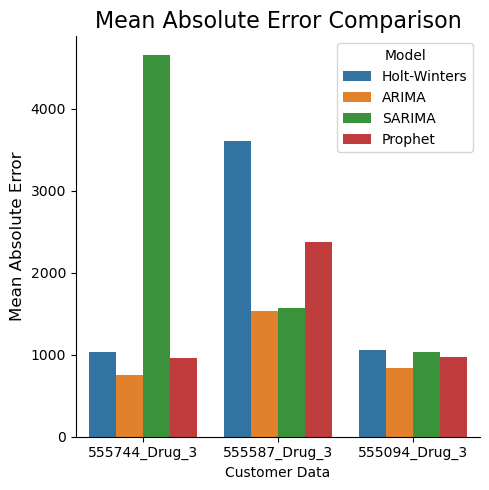

In [236]:
sns.catplot(
    data=dfComparison.reset_index(), kind="bar",
    x="Data", y="MeanAbsoluteError", hue="Model", legend=False
)
plt.title("Mean Absolute Error Comparison", fontsize=16)
plt.ylabel("Mean Absolute Error", fontsize=12)
plt.xlabel("Customer Data")
plt.legend(title="Model")
plt.tight_layout()
# plt.savefig(f"Forecasting/mae_comparison.png")
plt.show()

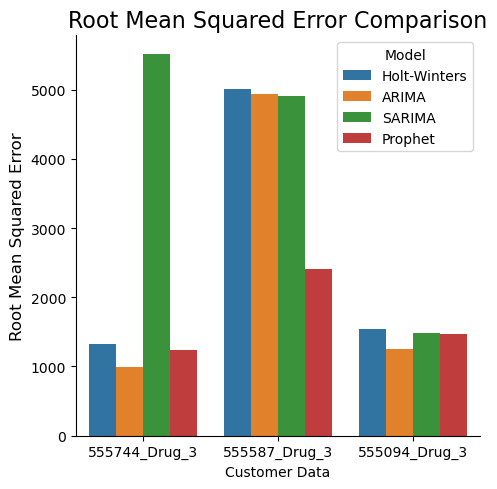

In [237]:
sns.catplot(
    data=dfComparison.reset_index(), kind="bar",
    x="Data", y="RootMeanSquaredError", hue="Model", legend=False
)
plt.title("Root Mean Squared Error Comparison", fontsize=16)
plt.ylabel("Root Mean Squared Error", fontsize=12)
plt.xlabel("Customer Data")
plt.legend(title="Model")
plt.tight_layout()
# plt.savefig(f"Forecasting/rmse_comparison.png")
plt.show()

# Product Price Optimization
## Price is based on the product itself

In [220]:
mpl.rc_file_defaults()
dfAggSKU

pk_sku2      qty           amt  \
15736  7288005878Drug_337492202012555590  23865.0  5.674153e+06   
1194    53005240Drug_1404637202103555590  36060.0  5.032420e+06   
24168  7288084456Drug_137492202010555590  29425.0  4.137322e+06   
27604  7288837668Drug_337492202105555590  16380.0  3.805952e+06   
27092  7288825665Drug_337492202103555590  15525.0  3.684334e+06   
...                                  ...      ...           ...   
1467    53006280Drug_1404637202104555775      1.0  1.621045e+01   
10070  7280088058Drug_237492201912555550      1.0  1.220496e+01   
9337   7280085354Drug_237492201912555997      1.0  8.859199e+00   
196     53000483Drug_2404637202102555855      1.0  7.539744e+00   
11093  7280840063Drug_237492201901555550      1.0  7.539744e+00   

       acct_doc_nmbr  fscl_yr  fscl_mo fscl_yr_mo  cmpny_id prod_name  \
15736     7288005878     2020       12 2020-12-01     37492    Drug_3   
1194        53005240     2021        3 2021-03-01    404637    Drug_1   
24168     7288084456     2020       10 2020-10-01     37492    Drug_1   
27604     7288837668     2021        5 2021-05-01     37492    Drug_3   
27092     7288825665     2021        3 2021-03-01     37492    Drug_3   
...              ...      ...      ...        ...       ...       ...   
1467        53006280     2021        4 2021-04-01    404637    Drug_1   
10070     7280088058     2019       12 2019-12-01     37492    Drug_2   
9337      7280085354     2019       12 2019-12-01     37492    Drug_2   
196         53000483     2021        2 2021-02-01    404637    Drug_2   
11093     7280840063     2019        1 2019-01-01     37492    Drug_2   

            cust_group cust_id     cust_name   pstng_dt  \
15736    MISCELLANEOUS  555590   Customer_12 2020-12-02   
1194     MISCELLANEOUS  555590   Customer_12 2021-03-29   
24168    MISCELLANEOUS  555590   Customer_12 2020-10-29   
27604    MISCELLANEOUS  555590   Customer_12 2021-05-11   
27092    MISCELLANEOUS  555590   Customer_12 2021-03-25   
...                ...     ...           ...        ...   
1467          HOSPITAL  555775  Customer_403 2021-04-09   
10070         HOSPITAL  555550  Customer_259 2019-12-17   
9337     MISCELLANEOUS  555997    Customer_8 2019-12-30   
196      MISCELLANEOUS  555855    Customer_2 2021-02-08   
11093  RETAIL_PHARMACY  555550  Customer_178 2019-01-25   

                            pk_sku      deducAmt  retailPrice        netAmt  
15736  7288005878Drug_337492202012 -2.235293e+06       237.76  3.438860e+06  
1194    53005240Drug_1404637202103 -4.031680e+06       139.56  1.000740e+06  
24168  7288084456Drug_137492202010 -3.201452e+06       140.61  9.358700e+05  
27604  7288837668Drug_337492202105 -1.616269e+06       232.35  2.189683e+06  
27092  7288825665Drug_337492202103 -1.575473e+06       237.32  2.108860e+06  
...                            ...           ...          ...           ...  
1467    53006280Drug_1404637202104 -1.696065e+03        16.21 -1.679855e+03  
10070  7280088058Drug_237492201912 -1.837813e+00        12.20  1.036715e+01  
9337   7280085354Drug_237492201912 -9.424680e-02         8.86  8.764952e+00  
196     53000483Drug_2404637202102 -9.424680e-02         7.54  7.445497e+00  
11093  7280840063Drug_237492201901 -4.712340e-01         7.54  7.068510e+00  

[25412 rows x 17 columns]

In [221]:
dfPrice = dfAggSKU.groupby(['fscl_yr_mo', 'prod_name'], as_index=False).agg({'amt': 'mean', 'qty': 'mean', 'deducAmt': 'mean', 'netAmt': 'mean', 'retailPrice': 'mean'}).copy()
dfPrice['qty'] = round(dfPrice['qty'])
dfPrice

fscl_yr_mo prod_name           amt    qty      deducAmt        netAmt  \
0  2019-01-01    Drug_2   8045.817192  329.0   -144.120857   7901.696335   
1  2019-01-01    Drug_3  50588.717221  212.0 -19025.840283  31562.876938   
2  2019-02-01    Drug_2   9405.945297  389.0   -195.724941   9210.220356   
3  2019-02-01    Drug_3  56599.924014  236.0 -21198.795786  35401.128228   
4  2019-03-01    Drug_2   9069.700171  385.0   -157.368223   8912.331948   
..        ...       ...           ...    ...           ...           ...   
80 2021-09-01    Drug_3  81490.313359  351.0 -35098.802238  46391.511121   
81 2021-10-01    Drug_3  75687.108973  328.0 -32046.429197  43640.679776   
82 2021-11-01    Drug_2   5061.053160  120.0  -1518.315948   3542.737212   
83 2021-11-01    Drug_3  80414.425819  348.0 -34428.166743  45986.259076   
84 2021-12-01    Drug_3  78467.669958  337.0 -33192.048008  45275.621951   

    retailPrice  
0     26.098382  
1    211.816195  
2     25.719395  
3    220.459718  
4     27.279905  
..          ...  
80   208.252452  
81   202.216878  
82    42.180000  
83   201.522898  
84   202.502736  

[85 rows x 7 columns]

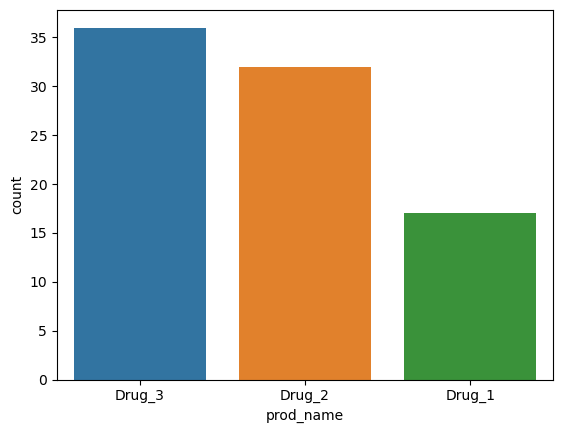

In [222]:
# Count the number of records for each drug product
sns.countplot(data=dfPrice, x=dfPrice['prod_name'], order = dfPrice['prod_name'].value_counts().index)
plt.show()

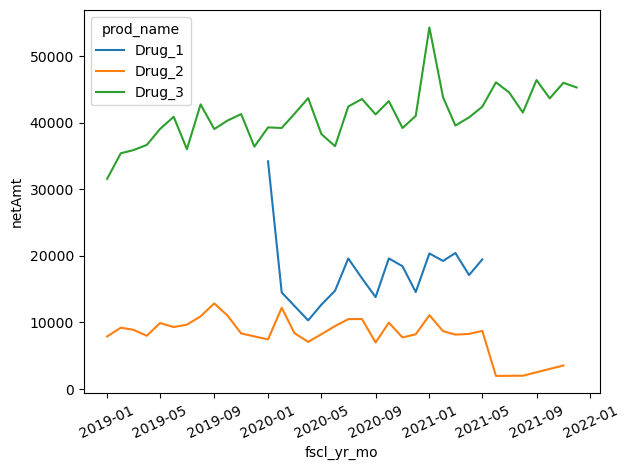

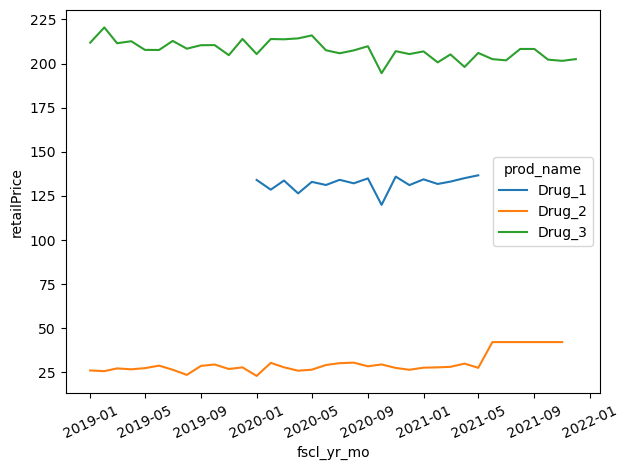

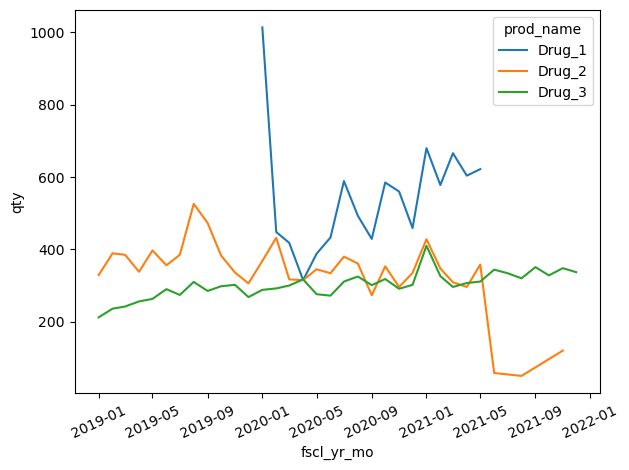

In [223]:
# Show the numbers from each drug product from 2019-2021. Drug 1 and 2 does not have full data within those years
sns.lineplot(data=dfPrice.sort_values(by='prod_name'), x='fscl_yr_mo', y='netAmt', hue='prod_name')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

sns.lineplot(data=dfPrice.sort_values(by='prod_name'), x='fscl_yr_mo', y='retailPrice', hue='prod_name')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

sns.lineplot(data=dfPrice.sort_values(by='prod_name'), x='fscl_yr_mo', y='qty', hue='prod_name')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

In [224]:
# Get the most complete data from a drug product
dfPrice = dfPrice[dfPrice['prod_name'] == dfPrice['prod_name'].value_counts().index[0]].reset_index()
dfPrice.tail()

index fscl_yr_mo prod_name           amt    qty      deducAmt  \
31     79 2021-08-01    Drug_3  74037.550305  320.0 -32525.914860   
32     80 2021-09-01    Drug_3  81490.313359  351.0 -35098.802238   
33     81 2021-10-01    Drug_3  75687.108973  328.0 -32046.429197   
34     83 2021-11-01    Drug_3  80414.425819  348.0 -34428.166743   
35     84 2021-12-01    Drug_3  78467.669958  337.0 -33192.048008   

          netAmt  retailPrice  
31  41511.635444   208.260370  
32  46391.511121   208.252452  
33  43640.679776   202.216878  
34  45986.259076   201.522898  
35  45275.621951   202.502736

In [225]:
dfPrice

index fscl_yr_mo prod_name           amt    qty      deducAmt  \
0       1 2019-01-01    Drug_3  50588.717221  212.0 -19025.840283   
1       3 2019-02-01    Drug_3  56599.924014  236.0 -21198.795786   
2       5 2019-03-01    Drug_3  57489.001445  242.0 -21626.719801   
3       7 2019-04-01    Drug_3  60473.975186  256.0 -23819.917383   
4       9 2019-05-01    Drug_3  62520.598398  263.0 -23471.658409   
5      11 2019-06-01    Drug_3  68202.602134  290.0 -27325.988762   
6      13 2019-07-01    Drug_3  63610.736610  274.0 -27602.444965   
7      15 2019-08-01    Drug_3  73270.623421  310.0 -30530.577395   
8      17 2019-09-01    Drug_3  67909.513615  285.0 -28879.881498   
9      19 2019-10-01    Drug_3  69920.827271  298.0 -29611.552721   
10     21 2019-11-01    Drug_3  70714.404239  302.0 -29430.769766   
11     23 2019-12-01    Drug_3  63251.130719  268.0 -26851.874758   
12     26 2020-01-01    Drug_3  67294.333409  288.0 -28007.754389   
13     29 2020-02-01    Drug_3  67635.988306  292.0 -28439.418279   
14     32 2020-03-01    Drug_3  71165.575354  300.0 -29836.611673   
15     35 2020-04-01    Drug_3  74484.595661  317.0 -30807.987185   
16     38 2020-05-01    Drug_3  65030.850725  276.0 -26748.342485   
17     41 2020-06-01    Drug_3  62958.130888  272.0 -26493.102639   
18     44 2020-07-01    Drug_3  72529.370090  311.0 -30106.919955   
19     47 2020-08-01    Drug_3  75410.321378  325.0 -31866.144046   
20     50 2020-09-01    Drug_3  70333.825228  301.0 -29094.618090   
21     53 2020-10-01    Drug_3  70327.293670  318.0 -27094.987577   
22     56 2020-11-01    Drug_3  67875.988876  291.0 -28683.667152   
23     59 2020-12-01    Drug_3  70355.206919  302.0 -29345.986351   
24     62 2021-01-01    Drug_3  95547.029559  410.0 -41252.258488   
25     65 2021-02-01    Drug_3  74248.357340  326.0 -30447.771054   
26     68 2021-03-01    Drug_3  68911.727313  296.0 -29343.295815   
27     71 2021-04-01    Drug_3  70891.236387  307.0 -30099.950078   
28     74 2021-05-01    Drug_3  72873.589685  311.0 -30479.782982   
29     76 2021-06-01    Drug_3  80186.165973  344.0 -34134.713986   
30     77 2021-07-01    Drug_3  77776.977420  334.0 -33250.405497   
31     79 2021-08-01    Drug_3  74037.550305  320.0 -32525.914860   
32     80 2021-09-01    Drug_3  81490.313359  351.0 -35098.802238   
33     81 2021-10-01    Drug_3  75687.108973  328.0 -32046.429197   
34     83 2021-11-01    Drug_3  80414.425819  348.0 -34428.166743   
35     84 2021-12-01    Drug_3  78467.669958  337.0 -33192.048008   

          netAmt  retailPrice  
0   31562.876938   211.816195  
1   35401.128228   220.459718  
2   35862.281644   211.500572  
3   36654.057803   212.642537  
4   39048.939988   207.739882  
5   40876.613371   207.677440  
6   36008.291644   212.817317  
7   42740.046026   208.414542  
8   39029.632117   210.390385  
9   40309.274550   210.440762  
10  41283.634473   204.746238  
11  36399.255961   213.940799  
12  39286.579020   205.365276  
13  39196.570027   213.895518  
14  41328.963682   213.733852  
15  43676.608476   214.246540  
16  38282.508241   215.934580  
17  36465.028249   207.527372  
18  42422.450134   205.817423  
19  43544.177332   207.448715  
20  41239.207138   209.806725  
21  43232.306093   194.538871  
22  39192.321724   207.015939  
23  41009.220568   205.365751  
24  54294.771071   206.873263  
25  43800.586286   200.664440  
26  39568.431497   205.161804  
27  40791.286310   198.065209  
28  42393.806703   206.001905  
29  46051.451986   202.492360  
30  44526.571923   201.804581  
31  41511.635444   208.260370  
32  46391.511121   208.252452  
33  43640.679776   202.216878  
34  45986.259076   201.522898  
35  45275.621951   202.502736

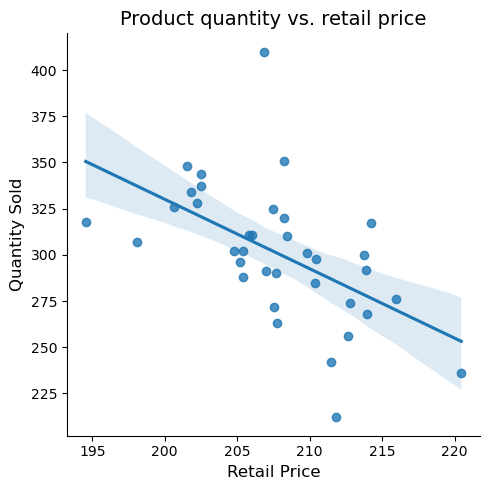

In [226]:
# Demand curve using lmplot, similar to regression plot (regplot)
sns.lmplot(x = "retailPrice", y = "qty", data = dfPrice)
plt.title("Product quantity vs. retail price", fontsize=14)
plt.xlabel('Retail Price', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.tight_layout()
# plt.savefig(f"Optimization/regression_plot.png")
plt.show()
    # plt.figure(figsize=(12,6))
    # plt.plot(tsTrain, label='Train')
    # plt.plot(tsTest, label='Test')
    # plt.plot(sarimaResult, label='SARIMA')
    # plt.legend(loc='best')
    # plt.xticks(rotation=25)
    # plt.show()

**A pattern can be seen where the higher the retail price, the lower the quantity is.**

## Splitting of dataset & model evaluation

In [227]:
x = dfPrice[['retailPrice']]
y = dfPrice['qty']

# reg = linear_model.LinearRegression()
# dfValidation = pd.DataFrame(columns=['Split Type','Avg RMSE'])
# rsmeArr = []

# for i in range(5, 11):
#     cv = KFold(n_splits=i, random_state=42, shuffle=True)
#     for train_index, test_index in cv.split(x):
#         # print("TRAIN:", train_index, "TEST:", test_index)
#         x_train, x_test = x.iloc[train_index], x.iloc[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         reg.fit(x_train, y_train)
#         y_pred = reg.predict(x_test)
#         rmse = mean_squared_error(y_test, y_pred, squared=False)
#         rsmeArr.append(rmse)
#     dfValidation = dfValidation.append({'Split Type':"K-fold " + str(i),'Avg RMSE':np.mean(rsmeArr)},ignore_index=True)
#     print(f"Average RSME of KFold {i} = {np.mean(rsmeArr)}")

# sns.barplot(data=dfValidation, x='Split Type', y='Avg RMSE').set(title="RMSE comparison of K-Fold Validation (Lower is better)")
# plt.xlabel('K-Fold Splits')
# plt.ylabel('Average RMSE')
# plt.xticks(rotation=15)
# plt.show()

dfEvaluation = pd.DataFrame(columns=['Model', 'MeanAbsoluteError', 'RootMeanSquareError'])
# dfValidation = pd.Dataframe(columns=['OLS', 'Ridge', 'Lasso', 'ElasticNet'])
olsReg = linear_model.LinearRegression()
ridgeReg = linear_model.Ridge()
lassoReg = linear_model.Lasso()
enReg = linear_model.ElasticNet()

olsMAE = []
olsRSME = []
ridgeMAE = []
ridgeRSME = []
lassoMAE = []
lassoRSME = []
enMAE = []
enRSME = []


# cv = KFold(n_splits=10, random_state=42, shuffle=True)
# for train_index, test_index in cv.split(x):
# print("TRAIN:", train_index, "TEST:", test_index)
# x_train, x_test = x.iloc[train_index], x.iloc[test_index]
# y_train, y_test = y[train_index], y[test_index]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42, shuffle=True)

# OLS Regression
olsReg.fit(x_train, y_train)
y_pred = olsReg.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
olsMAE.append(mae)
olsRSME.append(rmse)

# Ridge Regression
ridgeReg.fit(x_train, y_train)
y_pred = ridgeReg.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
ridgeMAE.append(mae)
ridgeRSME.append(rmse)

# Lasso Regression
lassoReg.fit(x_train, y_train)
y_pred = lassoReg.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
lassoMAE.append(mae)
lassoRSME.append(rmse)

# Elastic-Net Regression
enReg.fit(x_train, y_train)
y_pred = enReg.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
enMAE.append(mae)
enRSME.append(rmse)

olsMAE = np.mean(olsMAE)
olsRSME = np.mean(olsRSME)
ridgeMAE = np.mean(ridgeMAE)
ridgeRSME = np.mean(ridgeRSME)
lassoMAE = np.mean(lassoMAE)
lassoRSME = np.mean(lassoRSME)
enMAE = np.mean(enMAE)
enRSME = np.mean(enRSME)

dfEvaluation = dfEvaluation.append({'Model':"OLS",'MeanAbsoluteError':olsMAE, 'RootMeanSquareError': olsRSME},ignore_index=True)
dfEvaluation = dfEvaluation.append({'Model':"Ridge",'MeanAbsoluteError':ridgeMAE, 'RootMeanSquareError': ridgeRSME},ignore_index=True)
dfEvaluation = dfEvaluation.append({'Model':"Lasso",'MeanAbsoluteError':lassoMAE, 'RootMeanSquareError': lassoRSME},ignore_index=True)
dfEvaluation = dfEvaluation.append({'Model':"Elastic-Net",'MeanAbsoluteError':enMAE, 'RootMeanSquareError': enRSME},ignore_index=True)
    

# Testing using standard train test split
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42, shuffle=True)

# enReg.fit(x_train, y_train)

# y_pred = reg.predict(x_test)

# print('TTS Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
# print('TTS Mean Squared Error:', mean_squared_error(y_test, y_pred))
# print('TTS Root Mean Squared Error:', mean_squared_error(y_test, y_pred, squared=False))

# dfRMSE = dfRMSE.append({'Split Type':"Train-Test-Split 0.33",'Avg RMSE':mean_squared_error(y_test, y_pred, squared=False)},ignore_index=True)
# display(dfRMSE)

display(dfEvaluation)

C:\Users\dustb\AppData\Local\Temp/ipykernel_9396/1776605619.py:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfEvaluation = dfEvaluation.append({'Model':"OLS",'MeanAbsoluteError':olsMAE, 'RootMeanSquareError': olsRSME},ignore_index=True)
C:\Users\dustb\AppData\Local\Temp/ipykernel_9396/1776605619.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfEvaluation = dfEvaluation.append({'Model':"Ridge",'MeanAbsoluteError':ridgeMAE, 'RootMeanSquareError': ridgeRSME},ignore_index=True)
C:\Users\dustb\AppData\Local\Temp/ipykernel_9396/1776605619.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfEvaluation = dfEvaluation.append({'Model':"Lasso",'MeanAbsoluteError':lassoMAE, 'RootMeanSquareError': lassoRSME},ignore_index=T

Model MeanAbsoluteError RootMeanSquareError
0          OLS         17.745858           20.506858
1        Ridge         17.736535           20.486198
2        Lasso         17.695086           20.395321
3  Elastic-Net         17.611186           20.216302

In [265]:
# dfComparison.reset_index().round(2)
dfEvaluation['MeanAbsoluteError'] = dfEvaluation['MeanAbsoluteError'].astype(float).round(2)
dfEvaluation['RootMeanSquareError'] = dfEvaluation['RootMeanSquareError'].astype(float).round(2)
dfEvaluation

Model  MeanAbsoluteError  RootMeanSquareError
0          OLS              17.75                20.51
1        Ridge              17.74                20.49
2        Lasso              17.70                20.40
3  Elastic-Net              17.61                20.22

In [276]:
dfEvaluation.mean()

C:\Users\dustb\AppData\Local\Temp/ipykernel_9396/154521409.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dfEvaluation.mean()


MeanAbsoluteError      17.700
RootMeanSquareError    20.405
dtype: float64

In [229]:
y_test.mean()

305.3333333333333

In [230]:
# Compare between test and predicted values
print(f"Regression intercept = {enReg.intercept_}")
print(f"Regression coefficient = {enReg.coef_[0]}")
# y_pred = np.round(y_pred)
# display(pd.DataFrame({'Actual Values': y_test, 'Predicted Values': y_pred, 'Accuracy Rate': 100 - abs((y_pred - y_test)/y_test)*100}))
# display(pd.DataFrame({'Actual Values': y_test, 'Predicted Values': y_pred, 'Accuracy Rate': 100 - abs((y_test - y_pred)/y_pred)*100}))

Regression intercept = 1195.8604460703737
Regression coefficient = -4.304939623978362


## Determine the demand function
- Formula -> **Dx = a + b(Px)**
  - Dx = quantity demanded of a product X [Dependent Variable]
  - a = intercept value
  - b = relationship between Dx and Px [Regression Coefficient]
  - Px = Price of product x
- Quantity demanded can be predicted with product price
- Intercept and coefficient value gained from the model can be used further to optimize prices by determining the best profit gained

Generate a list of potential drug prices:  [94, 109, 110, 120, 126, 128, 129, 135, 150, 159, 181, 183, 200, 213, 218, 220, 233, 261, 264, 269]


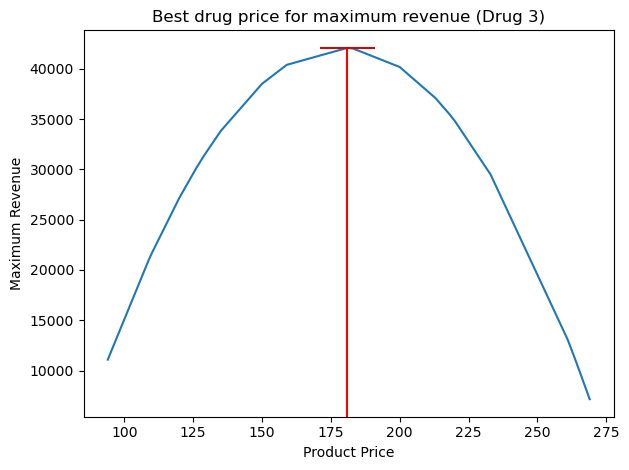

In [275]:
# Generate a range of different prices to find the optimum one
newPriceData = random.sample(range(int(dfPrice["retailPrice"].min()-100), int(dfPrice["retailPrice"].max()+50)), 20)
newPriceData.sort()
print("Generate a list of potential drug prices: ", newPriceData)

# Assuming a fixed product cost
cost = 80

revenueList = []
demandQtyList = []

for i in newPriceData:
    demandQty = enReg.intercept_ + (enReg.coef_[0] * i)
    revenueList.append(demandQty * (i-cost))

# create data frame of price and revenue
revenueDF = pd.DataFrame({"Price": newPriceData, "Revenue": revenueList})

# Get the best revenue and price
bestRevenue = revenueDF.loc[revenueDF['Revenue'].idxmax()]["Revenue"]
bestPrice = revenueDF.loc[revenueDF['Revenue'].idxmax()]["Price"]

#plot revenue against price
plt.plot(revenueDF["Price"], revenueDF["Revenue"])
plt.axvline(x=bestPrice,ymax=0.95,color='red')
plt.hlines(y=bestRevenue, xmin=bestPrice-10, xmax=bestPrice+10, color='r')
plt.title('Best drug price for maximum revenue (Drug 3)')
plt.xlabel('Product Price')
plt.ylabel('Maximum Revenue')
plt.tight_layout()
# plt.savefig("Optimization/demand_curve.png")
plt.show()